# Dissecting Spotify Valence

In this assignment you will dissect Spotify's Valence metric.

---

> Panos Louridas, Associate Professor <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> louridas@aueb.gr


##### Lakkas Ioannis

Spotify uses a metric called *valence* to measure the happiness of a track. The metric itself, however, was not developed by Spotify. It was originally developed by Echo Nest, a company that was bought by Spotify in 2014. We don't know exactly how valence is calculated. Some details are given by a blog post, which you can find here:

https://web.archive.org/web/20170422195736/http://blog.echonest.com/post/66097438564/plotting-musics-emotional-valence-1950-2013

Your task is to untangle the mystery behind valence and propose how this is derived.

Spotify offers the following information that may be relevant to your task:

* [Get Track's Audio Features](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features) and [Get Tracks' Audio Features](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features).

* [Get Track's Audio Analysis](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-analysis).

The rank of your assignment will contribute to the grade. That is, if $x$ is the unranked grade of an assignment and $r$ is the respective model’s ranking among $n$ students according to Q2 below, then the final grade will be computed as $0.75x + 2.5[1 - (r-1)/(n-1)]$. 

In [1]:
import pandas as pd
import numpy as np
import glob
import re
from datetime import datetime
import itertools
import os
from pathlib import Path

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from spotify_config import config

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn import tree
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

from xgboost import XGBRegressor
import xgboost as xgb
from xgboost import plot_importance

from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
header = 0
dfs = []
for file in glob.glob(os.path.join('Charts', '*', '201?','*.csv' )):
    region = file.split('\\')[1]
    dates = re.findall('\d{4}-\d{2}-\d{2}', file.split('\\')[-1])
    weekly_chart = pd.read_csv(file, header=header, sep='\t')
    weekly_chart['week_start'] = datetime.strptime(dates[0], '%Y-%m-%d')
    weekly_chart['week_end'] = datetime.strptime(dates[1], '%Y-%m-%d')
    weekly_chart['region'] = region
    dfs.append(weekly_chart)

all_charts = pd.concat(dfs)
all_charts

position                 song_id  \
0           1  5aAx2yezTd8zXrkmtKl66Z   
1           2  5knuzwU65gJK7IF5yJsuaW   
2           3  7BKLCZ1jbUBVqRi2FVlTVw   
3           4  3NdDpSvN911VPGivFlV5d0   
4           5  78rIJddV4X0HkNAInEcYde   
..        ...                     ...   
195       196  7f5trao56t7sB7f14QDTmp   
196       197  5JiH89mHrv9oWHlD0T326z   
197       198  7GX5flRQZVHRAGd6B4TmDO   
198       199  2dpaYNEQHiRxtZbfNsse99   
199       200  5BJMeoCXXgbRAWfp6fTulr   

                                             song_name            artist  \
0                                              Starboy        The Weeknd   
1              Rockabye (feat. Sean Paul & Anne-Marie)      Clean Bandit   
2                                               Closer  The Chainsmokers   
3    I Don’t Wanna Live Forever (Fifty Shades Darke...              ZAYN   
4              Call On Me - Ryan Riback Extended Remix           Starley   
..                                                 ...               ...   
195                                              Juicy          Doja Cat   
196                                    To Be So Lonely      Harry Styles   
197                                      XO Tour Llif3      Lil Uzi Vert   
198                                            Happier        Marshmello   
199               Shotta Flow (feat. Blueface) [Remix]        NLE Choppa   

     streams  last_week_position  weeks_on_chart  peak_position  \
0     947261                 NaN               1              1   
1     893107                 NaN               1              2   
2     871617                 NaN               1              3   
3     791592                 NaN               1              4   
4     743490                 NaN               1              5   
..       ...                 ...             ...            ...   
195  1920454               146.0               8             66   
196  1912267                32.0               2             32   
197  1902239               154.0             121              2   
198  1899623               173.0              71              8   
199  1899350                 NaN               1            200   

    position_status week_start   week_end region  
0               new 2016-12-30 2017-01-06     au  
1               new 2016-12-30 2017-01-06     au  
2               new 2016-12-30 2017-01-06     au  
3               new 2016-12-30 2017-01-06     au  
4               new 2016-12-30 2017-01-06     au  
..              ...        ...        ...    ...  
195             -50 2019-12-20 2019-12-27     us  
196            -165 2019-12-20 2019-12-27     us  
197             -44 2019-12-20 2019-12-27     us  
198             -26 2019-12-20 2019-12-27     us  
199             new 2019-12-20 2019-12-27     us  

[273600 rows x 12 columns]

* There are tens of thousands of songs in the charts, but not all of them are unique(something sound as we are talking for charts):

In [3]:
len(all_charts['song_id'].unique())

13880

* For storing our credentials, we'll create a file `spotify_config.py` with the following contents:

  ```
  config = {
      'client_id' : 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX',
      'client_secret' :'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
  }
  ```

* Then we can create a Spotify client.

In [4]:
client_credentials_manager = SpotifyClientCredentials(config['client_id'],
                                                      config['client_secret'])
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

* We will get, for each of the top-streaming tracks, its [audio features](https://developer.spotify.com/documentation/web-api/reference/#endpoint-get-several-audio-features).

* To do that, we'll create a dictionary keyed by `song_id`, with values being the audio features for the specific track.

* But before doing this we will read the extra data set(test set), in order to fetch and this data too.

In [5]:
my_file = open("spotify_ids.txt", "r")
content = my_file.read()
content_list = content.split("\n")
my_file.close()

In [6]:
extra_df = pd.DataFrame(content_list, columns =['song_id'])

In [7]:
result = all_charts.append(extra_df)

In [8]:
features = {}
all_track_ids = list(result['song_id'].unique())

* The call for getting several audio features can get no more than 100 at a time, so we'll have to iterate.

In [9]:
start = 0
num_tracks = 100
while start < len(all_track_ids):
    print(f'getting from {start} to {start+num_tracks}')
    tracks_batch = all_track_ids[start:start+num_tracks]
    features_batch = sp.audio_features(tracks_batch)
    features.update({ track_id : track_features 
                     for track_id, track_features in zip(tracks_batch, features_batch) })
    start += num_tracks

getting from 0 to 100
getting from 100 to 200
getting from 200 to 300
getting from 300 to 400
getting from 400 to 500
getting from 500 to 600
getting from 600 to 700
getting from 700 to 800
getting from 800 to 900
getting from 900 to 1000
getting from 1000 to 1100
getting from 1100 to 1200
getting from 1200 to 1300
getting from 1300 to 1400
getting from 1400 to 1500
getting from 1500 to 1600
getting from 1600 to 1700
getting from 1700 to 1800
getting from 1800 to 1900
getting from 1900 to 2000
getting from 2000 to 2100
getting from 2100 to 2200
getting from 2200 to 2300
getting from 2300 to 2400
getting from 2400 to 2500
getting from 2500 to 2600
getting from 2600 to 2700
getting from 2700 to 2800
getting from 2800 to 2900
getting from 2900 to 3000
getting from 3000 to 3100
getting from 3100 to 3200
getting from 3200 to 3300
getting from 3300 to 3400
getting from 3400 to 3500
getting from 3500 to 3600
getting from 3600 to 3700
getting from 3700 to 3800
getting from 3800 to 3900
getting

* Let's verify that we got all of them:

In [10]:
len(features)

14911

* And this is how the features look like:

In [11]:
features['7qiZfU4dY1lWllzX7mPBI3']

{'danceability': 0.825,
 'energy': 0.652,
 'key': 1,
 'loudness': -3.183,
 'mode': 0,
 'speechiness': 0.0802,
 'acousticness': 0.581,
 'instrumentalness': 0,
 'liveness': 0.0931,
 'valence': 0.931,
 'tempo': 95.977,
 'type': 'audio_features',
 'id': '7qiZfU4dY1lWllzX7mPBI3',
 'uri': 'spotify:track:7qiZfU4dY1lWllzX7mPBI3',
 'track_href': 'https://api.spotify.com/v1/tracks/7qiZfU4dY1lWllzX7mPBI3',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/7qiZfU4dY1lWllzX7mPBI3',
 'duration_ms': 233713,
 'time_signature': 4}

In [12]:
tracks = pd.DataFrame.from_dict(features, orient='index')
tracks

danceability  energy  key  loudness  mode  \
5aAx2yezTd8zXrkmtKl66Z         0.681   0.594    7    -7.028     1   
5knuzwU65gJK7IF5yJsuaW         0.720   0.763    9    -4.068     0   
7BKLCZ1jbUBVqRi2FVlTVw         0.748   0.524    8    -5.599     1   
3NdDpSvN911VPGivFlV5d0         0.735   0.451    0    -8.374     1   
78rIJddV4X0HkNAInEcYde         0.670   0.838    0    -4.031     1   
...                              ...     ...  ...       ...   ...   
4lUmnwRybYH7mMzf16xB0y         0.596   0.650    9    -5.167     1   
1fzf9Aad4y1RWrmwosAK5y         0.588   0.850    4    -6.431     1   
3E3pb3qH11iny6TFDJvsg5         0.754   0.660    0    -6.811     1   
3yTkoTuiKRGL2VAlQd7xsC         0.584   0.836    0    -4.925     1   
4JE6agBLHGA5TaF6FlqfBD         0.331   0.450   10    -5.362     1   

                        speechiness  acousticness  instrumentalness  liveness  \
5aAx2yezTd8zXrkmtKl66Z       0.2820        0.1650          0.000003    0.1340   
5knuzwU65gJK7IF5yJsuaW       0.0523        0.4060          0.000000    0.1800   
7BKLCZ1jbUBVqRi2FVlTVw       0.0338        0.4140          0.000000    0.1110   
3NdDpSvN911VPGivFlV5d0       0.0585        0.0631          0.000013    0.3250   
78rIJddV4X0HkNAInEcYde       0.0362        0.0604          0.000611    0.1590   
...                             ...           ...               ...       ...   
4lUmnwRybYH7mMzf16xB0y       0.3370        0.1380          0.000000    0.1400   
1fzf9Aad4y1RWrmwosAK5y       0.0318        0.1680          0.002020    0.0465   
3E3pb3qH11iny6TFDJvsg5       0.2670        0.1790          0.000000    0.1940   
3yTkoTuiKRGL2VAlQd7xsC       0.0790        0.0558          0.000000    0.0663   
4JE6agBLHGA5TaF6FlqfBD       0.0340        0.3650          0.004640    0.2200   

                        valence    tempo            type  \
5aAx2yezTd8zXrkmtKl66Z   0.5350  186.054  audio_features   
5knuzwU65gJK7IF5yJsuaW   0.7420  101.965  audio_features   
7BKLCZ1jbUBVqRi2FVlTVw   0.6610   95.010  audio_features   
3NdDpSvN911VPGivFlV5d0   0.0862  117.973  audio_features   
78rIJddV4X0HkNAInEcYde   0.7170  104.998  audio_features   
...                         ...      ...             ...   
4lUmnwRybYH7mMzf16xB0y   0.1880  133.997  audio_features   
1fzf9Aad4y1RWrmwosAK5y   0.7680   93.003  audio_features   
3E3pb3qH11iny6TFDJvsg5   0.3160   83.000  audio_features   
3yTkoTuiKRGL2VAlQd7xsC   0.4840  104.973  audio_features   
4JE6agBLHGA5TaF6FlqfBD   0.1800  123.829  audio_features   

                                            id  \
5aAx2yezTd8zXrkmtKl66Z  5aAx2yezTd8zXrkmtKl66Z   
5knuzwU65gJK7IF5yJsuaW  5knuzwU65gJK7IF5yJsuaW   
7BKLCZ1jbUBVqRi2FVlTVw  7BKLCZ1jbUBVqRi2FVlTVw   
3NdDpSvN911VPGivFlV5d0  3NdDpSvN911VPGivFlV5d0   
78rIJddV4X0HkNAInEcYde  78rIJddV4X0HkNAInEcYde   
...                                        ...   
4lUmnwRybYH7mMzf16xB0y  4lUmnwRybYH7mMzf16xB0y   
1fzf9Aad4y1RWrmwosAK5y  1fzf9Aad4y1RWrmwosAK5y   
3E3pb3qH11iny6TFDJvsg5  3E3pb3qH11iny6TFDJvsg5   
3yTkoTuiKRGL2VAlQd7xsC  3yTkoTuiKRGL2VAlQd7xsC   
4JE6agBLHGA5TaF6FlqfBD  4JE6agBLHGA5TaF6FlqfBD   

                                                         uri  \
5aAx2yezTd8zXrkmtKl66Z  spotify:track:5aAx2yezTd8zXrkmtKl66Z   
5knuzwU65gJK7IF5yJsuaW  spotify:track:5knuzwU65gJK7IF5yJsuaW   
7BKLCZ1jbUBVqRi2FVlTVw  spotify:track:7BKLCZ1jbUBVqRi2FVlTVw   
3NdDpSvN911VPGivFlV5d0  spotify:track:3NdDpSvN911VPGivFlV5d0   
78rIJddV4X0HkNAInEcYde  spotify:track:78rIJddV4X0HkNAInEcYde   
...                                                      ...   
4lUmnwRybYH7mMzf16xB0y  spotify:track:4lUmnwRybYH7mMzf16xB0y   
1fzf9Aad4y1RWrmwosAK5y  spotify:track:1fzf9Aad4y1RWrmwosAK5y   
3E3pb3qH11iny6TFDJvsg5  spotify:track:3E3pb3qH11iny6TFDJvsg5   
3yTkoTuiKRGL2VAlQd7xsC  spotify:track:3yTkoTuiKRGL2VAlQd7xsC   
4JE6agBLHGA5TaF6FlqfBD  spotify:track:4JE6agBLHGA5TaF6FlqfBD   

                                                               track_href  \
5aAx2yezTd8zXrkmtKl66Z  https://api.spotify.com/v1/tra

* We'll move the index as a column called `song_id`.

In [13]:
tracks = tracks.reset_index().rename(columns={'index' : 'song_id'})
tracks

song_id  danceability  energy  key  loudness  mode  \
0      5aAx2yezTd8zXrkmtKl66Z         0.681   0.594    7    -7.028     1   
1      5knuzwU65gJK7IF5yJsuaW         0.720   0.763    9    -4.068     0   
2      7BKLCZ1jbUBVqRi2FVlTVw         0.748   0.524    8    -5.599     1   
3      3NdDpSvN911VPGivFlV5d0         0.735   0.451    0    -8.374     1   
4      78rIJddV4X0HkNAInEcYde         0.670   0.838    0    -4.031     1   
...                       ...           ...     ...  ...       ...   ...   
14906  4lUmnwRybYH7mMzf16xB0y         0.596   0.650    9    -5.167     1   
14907  1fzf9Aad4y1RWrmwosAK5y         0.588   0.850    4    -6.431     1   
14908  3E3pb3qH11iny6TFDJvsg5         0.754   0.660    0    -6.811     1   
14909  3yTkoTuiKRGL2VAlQd7xsC         0.584   0.836    0    -4.925     1   
14910  4JE6agBLHGA5TaF6FlqfBD         0.331   0.450   10    -5.362     1   

       speechiness  acousticness  instrumentalness  liveness  valence  \
0           0.2820        0.1650          0.000003    0.1340   0.5350   
1           0.0523        0.4060          0.000000    0.1800   0.7420   
2           0.0338        0.4140          0.000000    0.1110   0.6610   
3           0.0585        0.0631          0.000013    0.3250   0.0862   
4           0.0362        0.0604          0.000611    0.1590   0.7170   
...            ...           ...               ...       ...      ...   
14906       0.3370        0.1380          0.000000    0.1400   0.1880   
14907       0.0318        0.1680          0.002020    0.0465   0.7680   
14908       0.2670        0.1790          0.000000    0.1940   0.3160   
14909       0.0790        0.0558          0.000000    0.0663   0.4840   
14910       0.0340        0.3650          0.004640    0.2200   0.1800   

         tempo            type                      id  \
0      186.054  audio_features  5aAx2yezTd8zXrkmtKl66Z   
1      101.965  audio_features  5knuzwU65gJK7IF5yJsuaW   
2       95.010  audio_features  7BKLCZ1jbUBVqRi2FVlTVw   
3      117.973  audio_features  3NdDpSvN911VPGivFlV5d0   
4      104.998  audio_features  78rIJddV4X0HkNAInEcYde   
...        ...             ...                     ...   
14906  133.997  audio_features  4lUmnwRybYH7mMzf16xB0y   
14907   93.003  audio_features  1fzf9Aad4y1RWrmwosAK5y   
14908   83.000  audio_features  3E3pb3qH11iny6TFDJvsg5   
14909  104.973  audio_features  3yTkoTuiKRGL2VAlQd7xsC   
14910  123.829  audio_features  4JE6agBLHGA5TaF6FlqfBD   

                                        uri  \
0      spotify:track:5aAx2yezTd8zXrkmtKl66Z   
1      spotify:track:5knuzwU65gJK7IF5yJsuaW   
2      spotify:track:7BKLCZ1jbUBVqRi2FVlTVw   
3      spotify:track:3NdDpSvN911VPGivFlV5d0   
4      spotify:track:78rIJddV4X0HkNAInEcYde   
...                                     ...   
14906  spotify:track:4lUmnwRybYH7mMzf16xB0y   
14907  spotify:track:1fzf9Aad4y1RWrmwosAK5y   
14908  spotify:track:3E3pb3qH11iny6TFDJvsg5   
14909  spotify:track:3yTkoTuiKRGL2VAlQd7xsC   
14910  spotify:track:4JE6agBLHGA5TaF6FlqfBD   

                                              track_href  \
0      https://api.spotify.com/v1/tracks/5aAx2yezTd8z...   
1      https://api.spotify.com/v1/tracks/5knuzwU65gJK...   
2      https://api.spotify.com/v1/tracks/7BKLCZ1jbUBV...   
3      https://api.spotify.com/v1/tracks/3NdDpSvN911V...   
4      https://api.spotify.com/v1/tracks/78rIJddV4X0H...   
...                                                  ...   
14906  https://api.spotify.com/v1/tracks/4lUmnwRybYH7...   
14907  https://api.spotify.com/v1/tracks/1fzf9Aad4y1R...   
14908  https://api.spotify.com/v1/tracks/3E3pb3qH11in...   
14909  https://api.spotify.com/v1/tracks/3yTkoTuiKRGL...   
14910  https://api.spotify.com/v1/tracks/4JE6agBLHGA5...   

                                            analysis_url  duration_ms  \
0      https://api.spotify.com/v1/audio-analysis/5aAx...       230453   
1      https://api.spotify.com/v1/audio-analysis/5knu...       251088   
2      https://api.spotify.com

* Now we can join with the charts data, so that for each song we have any feature data we want.

In [14]:
all_charts = pd.merge(all_charts, tracks, on='song_id', how='right')
all_charts

position                 song_id song_name      artist   streams  \
0            1.0  5aAx2yezTd8zXrkmtKl66Z   Starboy  The Weeknd  947261.0   
1            3.0  5aAx2yezTd8zXrkmtKl66Z   Starboy  The Weeknd  950790.0   
2            4.0  5aAx2yezTd8zXrkmtKl66Z   Starboy  The Weeknd  943620.0   
3            6.0  5aAx2yezTd8zXrkmtKl66Z   Starboy  The Weeknd  860573.0   
4           11.0  5aAx2yezTd8zXrkmtKl66Z   Starboy  The Weeknd  755167.0   
...          ...                     ...       ...         ...       ...   
274626       NaN  4lUmnwRybYH7mMzf16xB0y       NaN         NaN       NaN   
274627       NaN  1fzf9Aad4y1RWrmwosAK5y       NaN         NaN       NaN   
274628       NaN  3E3pb3qH11iny6TFDJvsg5       NaN         NaN       NaN   
274629       NaN  3yTkoTuiKRGL2VAlQd7xsC       NaN         NaN       NaN   
274630       NaN  4JE6agBLHGA5TaF6FlqfBD       NaN         NaN       NaN   

        last_week_position  weeks_on_chart  peak_position position_status  \
0                      NaN             1.0            1.0             new   
1                      1.0             2.0            1.0              -2   
2                      3.0             3.0            1.0              -1   
3                      4.0             4.0            1.0              -2   
4                      6.0             5.0            1.0              -5   
...                    ...             ...            ...             ...   
274626                 NaN             NaN            NaN             NaN   
274627                 NaN             NaN            NaN             NaN   
274628                 NaN             NaN            NaN             NaN   
274629                 NaN             NaN            NaN             NaN   
274630                 NaN             NaN            NaN             NaN   

       week_start  ... liveness valence    tempo            type  \
0      2016-12-30  ...   0.1340   0.535  186.054  audio_features   
1      2017-01-06  ...   0.1340   0.535  186.054  audio_features   
2      2017-01-13  ...   0.1340   0.535  186.054  audio_features   
3      2017-01-20  ...   0.1340   0.535  186.054  audio_features   
4      2017-01-27  ...   0.1340   0.535  186.054  audio_features   
...           ...  ...      ...     ...      ...             ...   
274626        NaT  ...   0.1400   0.188  133.997  audio_features   
274627        NaT  ...   0.0465   0.768   93.003  audio_features   
274628        NaT  ...   0.1940   0.316   83.000  audio_features   
274629        NaT  ...   0.0663   0.484  104.973  audio_features   
274630        NaT  ...   0.2200   0.180  123.829  audio_features   

                            id                                   uri  \
0       5aAx2yezTd8zXrkmtKl66Z  spotify:track:5aAx2yezTd8zXrkmtKl66Z   
1       5aAx2yezTd8zXrkmtKl66Z  spotify:track:5aAx2yezTd8zXrkmtKl66Z   
2       5aAx2yezTd8zXrkmtKl66Z  spotify:track:5aAx2yezTd8zXrkmtKl66Z   
3       5aAx2yezTd8zXrkmtKl66Z  spotify:track:5aAx2yezTd8zXrkmtKl66Z   
4       5aAx2yezTd8zXrkmtKl66Z  spotify:track:5aAx2yezTd8zXrkmtKl66Z   
...                        ...                                   ...   
274626  4lUmnwRybYH7mMzf16xB0y  spotify:track:4lUmnwRybYH7mMzf16xB0y   
274627  1fzf9Aad4y1RWrmwosAK5y  spotify:track:1fzf9Aad4y1RWrmwosAK5y   
274628  3E3pb3qH11iny6TFDJvsg5  spotify:track:3E3pb3qH11iny6TFDJvsg5   
274629  3yTkoTuiKRGL2VAlQd7xsC  spotify:track:3yTkoTuiKRGL2VAlQd7xsC   
274630  4JE6agBLHGA5TaF6FlqfBD  spotify:track:4JE6agBLHGA5TaF6FlqfBD   

                                               track_href  \
0       https://api.spotify.com/v1/tracks/5aAx2yezTd8z...   
1       https://api.spotify.com/v1/tracks/5aAx2yezTd8z...   
2       https://api.spotify.com/v1/tracks/5aAx2yezTd8z...   
3       https://api.spotify.com/v1/tracks/5aAx2yezTd8z...   
4       https://api.spotify.com/v1/tracks/5aAx2yezTd8z...   
...                                                   ...   
274626  https://api.spotify.com/v1/tracks/4lUmnwRybYH7...   


In [15]:
all_charts.columns

Index(['position', 'song_id', 'song_name', 'artist', 'streams',
       'last_week_position', 'weeks_on_chart', 'peak_position',
       'position_status', 'week_start', 'week_end', 'region', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id', 'uri',
       'track_href', 'analysis_url', 'duration_ms', 'time_signature'],
      dtype='object')

* There are tens of thousands of songs in the charts, but not all of them are unique(something sound as we are talking for charts):

* We select the first 13880 rows as this is the data that we will use in this report.(the others are the extra from the given dataset,and they will be used after)

In [168]:
charts = all_charts.drop_duplicates(subset = ["song_id"]).copy()
df = charts[:13880].copy()
df

position                 song_id  \
0            1.0  5aAx2yezTd8zXrkmtKl66Z   
428          2.0  5knuzwU65gJK7IF5yJsuaW   
809          3.0  7BKLCZ1jbUBVqRi2FVlTVw   
1587         4.0  3NdDpSvN911VPGivFlV5d0   
2041         5.0  78rIJddV4X0HkNAInEcYde   
...          ...                     ...   
273595     187.0  3aQV6E290SJvasp2VOgvBz   
273596     117.0  43YQDj1KOPMFAUcTEPKy4p   
273597     162.0  1985nAkGJf1oOrgHCWftoN   
273598     184.0  7ntUbTIwmwOD6ygCMRZT6e   
273599     200.0  5BJMeoCXXgbRAWfp6fTulr   

                                                song_name            artist  \
0                                                 Starboy        The Weeknd   
428               Rockabye (feat. Sean Paul & Anne-Marie)      Clean Bandit   
809                                                Closer  The Chainsmokers   
1587    I Don’t Wanna Live Forever (Fifty Shades Darke...              ZAYN   
2041              Call On Me - Ryan Riback Extended Remix           Starley   
...                                                   ...               ...   
273595                 What I Please (feat. Denzel Curry)        Smokepurpp   
273596                                           Millions        Young Thug   
273597                                             Matrix        NLE Choppa   
273598  Writing on the Wall (feat. Post Malone, Cardi ...    French Montana   
273599               Shotta Flow (feat. Blueface) [Remix]        NLE Choppa   

          streams  last_week_position  weeks_on_chart  peak_position  \
0        947261.0                 NaN             1.0            1.0   
428      893107.0                 NaN             1.0            2.0   
809      871617.0                 NaN             1.0            3.0   
1587     791592.0                 NaN             1.0            4.0   
2041     743490.0                 NaN             1.0            5.0   
...           ...                 ...             ...            ...   
273595  1897382.0                 NaN             1.0          187.0   
273596  2483335.0                 NaN             1.0          117.0   
273597  2100003.0                 NaN             1.0          162.0   
273598  1973973.0                 NaN             1.0          184.0   
273599  1899350.0                 NaN             1.0          200.0   

       position_status week_start  ... liveness valence    tempo  \
0                  new 2016-12-30  ...   0.1340  0.5350  186.054   
428                new 2016-12-30  ...   0.1800  0.7420  101.965   
809                new 2016-12-30  ...   0.1110  0.6610   95.010   
1587               new 2016-12-30  ...   0.3250  0.0862  117.973   
2041               new 2016-12-30  ...   0.1590  0.7170  104.998   
...                ...        ...  ...      ...     ...      ...   
273595             new 2019-12-13  ...   0.1060  0.6180  139.970   
273596             new 2019-12-20  ...   0.0812  0.7400   99.027   
273597             new 2019-12-20  ...   0.1860  0.3280  150.051   
273598             new 2019-12-20  ...   0.0824  0.4940  112.014   
273599             new 2019-12-20  ...   0.1400  0.5670  120.077   

                  type                      id  \
0       audio_features  5aAx2yezTd8zXrkmtKl66Z   
428     audio_features  5knuzwU65gJK7IF5yJsuaW   
809     audio_features  7BKLCZ1jbUBVqRi2FVlTVw   
1587    audio_features  3NdDpSvN911VPGivFlV5d0   
2041    audio_features  78rIJddV4X0HkNAInEcYde   
...                ...                     ...   
273595  audio_features  3aQV6E290SJvasp2VOgvBz   
273596  audio_features  43YQDj1KOPMFAUcTEPKy4p   
273597  audio_features  1985nAkGJf1oOrgHCWftoN   
273598  audio_features  7ntUbTIwmwOD6ygCMRZT6e   
273599  audio_features  5BJMeoCXXgbRAWfp6fTulr   

                                         uri  \
0       spotify:track:5aAx2yezTd8zXrkmtKl66Z   
428     spotify:track:5knuzwU65gJK7IF5yJsuaW   
809     spotify:track:7BKLCZ1jbUBVqRi2FVlTVw   
1587    spotify:track:3NdDpSvN911VPGivFlV5d0   
2041   

* Extraction of month, that a track started to be on charts. It can be useful as a feature in our models.

In [17]:
month = df['week_start'].dt.month
month

0         12
428       12
809       12
1587      12
2041      12
          ..
273595    12
273596    12
273597    12
273598    12
273599    12
Name: week_start, Length: 13880, dtype: int64

* We drop some columns that are not useful in our models

In [169]:
df.drop(['analysis_url', 'id', 'track_href','uri','id','type','peak_position','last_week_position','weeks_on_chart','position_status','week_start','week_end','streams','region','position'], axis=1, inplace=True)

In [19]:
df

song_id  \
0       5aAx2yezTd8zXrkmtKl66Z   
428     5knuzwU65gJK7IF5yJsuaW   
809     7BKLCZ1jbUBVqRi2FVlTVw   
1587    3NdDpSvN911VPGivFlV5d0   
2041    78rIJddV4X0HkNAInEcYde   
...                        ...   
273595  3aQV6E290SJvasp2VOgvBz   
273596  43YQDj1KOPMFAUcTEPKy4p   
273597  1985nAkGJf1oOrgHCWftoN   
273598  7ntUbTIwmwOD6ygCMRZT6e   
273599  5BJMeoCXXgbRAWfp6fTulr   

                                                song_name            artist  \
0                                                 Starboy        The Weeknd   
428               Rockabye (feat. Sean Paul & Anne-Marie)      Clean Bandit   
809                                                Closer  The Chainsmokers   
1587    I Don’t Wanna Live Forever (Fifty Shades Darke...              ZAYN   
2041              Call On Me - Ryan Riback Extended Remix           Starley   
...                                                   ...               ...   
273595                 What I Please (feat. Denzel Curry)        Smokepurpp   
273596                                           Millions        Young Thug   
273597                                             Matrix        NLE Choppa   
273598  Writing on the Wall (feat. Post Malone, Cardi ...    French Montana   
273599               Shotta Flow (feat. Blueface) [Remix]        NLE Choppa   

        danceability  energy  key  loudness  mode  speechiness  acousticness  \
0              0.681   0.594    7    -7.028     1       0.2820       0.16500   
428            0.720   0.763    9    -4.068     0       0.0523       0.40600   
809            0.748   0.524    8    -5.599     1       0.0338       0.41400   
1587           0.735   0.451    0    -8.374     1       0.0585       0.06310   
2041           0.670   0.838    0    -4.031     1       0.0362       0.06040   
...              ...     ...  ...       ...   ...          ...           ...   
273595         0.810   0.690   10    -7.841     0       0.2700       0.03730   
273596         0.942   0.531    1    -7.510     1       0.2150       0.00236   
273597         0.762   0.679    4    -7.595     0       0.1920       0.04260   
273598         0.774   0.836    9    -2.323     0       0.1520       0.28800   
273599         0.894   0.511    2    -4.768     1       0.4210       0.02510   

        instrumentalness  liveness  valence    tempo  duration_ms  \
0               0.000003    0.1340   0.5350  186.054       230453   
428             0.000000    0.1800   0.7420  101.965       251088   
809             0.000000    0.1110   0.6610   95.010       244960   
1587            0.000013    0.3250   0.0862  117.973       245200   
2041            0.000611    0.1590   0.7170  104.998       222041   
...                  ...       ...      ...      ...          ...   
273595          0.000000    0.1060   0.6180  139.970       140369   
273596          0.000106    0.0812   0.7400   99.027       157520   
273597          0.000000    0.1860   0.3280  150.051       125320   
273598          0.000024    0.0824   0.4940  112.014       201271   
273599          0.000000    0.1400   0.5670  120.077       176632   

        time_signature  
0                    4  
428                  4  
809                  4  
1587                 4  
2041                 4  
...                ...  
273595               4  
273596               4  
273597               4  
273598               4  
273599               4  

[13880 rows x 16 columns]

* We take the 5 largest values of valence and the 5 smallest

In [20]:
df.nlargest(5, 'valence')

song_id  \
66472   1mqlc0vEP9mU1kZgTi6LIQ   
196754  25leEEaz1gIpp7o21Fqyjo   
244549  26mKegJko5IWWxTBgiXyW2   
260549  5EXJyRqlfZX7hXwUsbb9YQ   
79728   5xlS0QkVrSH7ssEbBgBzbM   

                                                song_name              artist  \
66472                                           September  Earth, Wind & Fire   
196754  Here Comes Santa Claus (Right Down Santa Claus...          Gene Autry   
244549                                        Africa Twin                 Jul   
260549                                        Renaissance              PUNPEE   
79728                      Little Saint Nick - 1991 Remix      The Beach Boys   

        danceability  energy  key  loudness  mode  speechiness  acousticness  \
66472          0.693   0.911    9    -3.691     1       0.0305        0.1830   
196754         0.834   0.371    1   -11.990     1       0.0358        0.7990   
244549         0.904   0.841    3    -5.920     0       0.0425        0.1100   
260549         0.725   0.867   10    -4.018     0       0.0798        0.0452   
79728          0.602   0.553   11    -9.336     1       0.0328        0.1080   

        instrumentalness  liveness  valence    tempo  duration_ms  \
66472           0.000107    0.3000    0.982  125.895       216520   
196754          0.000000    0.2750    0.976   96.628       150267   
244549          0.000000    0.0827    0.976  132.974       153707   
260549          0.037000    0.0719    0.972   95.555       218220   
79728           0.000000    0.0512    0.971  130.594       118840   

        time_signature  
66472                4  
196754               4  
244549               4  
260549               4  
79728                4

In [21]:
df.nsmallest(5, 'valence')

song_id                        song_name  \
218640  4naKZs7gN8cZDPXev78Sfb                            Davai   
203936  4czcw3NVLY0of5hTD7OufN                 Days in The East   
251029  0kDIirlQCy6YnmsK5pZ6PZ  I'm Not Alone - CamelPhat Remix   
108842  3jipFRgLyKK0oJoG1pKicx                            Jaded   
195100  65kp3OFn7JXbCvkm3m2Ui2                             Two®   

               artist  danceability  energy  key  loudness  mode  speechiness  \
218640       Kalazh44         0.723   0.630    1    -5.571     1       0.0501   
203936          Drake         0.733   0.361    1   -11.129     1       0.1350   
251029  Calvin Harris         0.575   0.969    1    -6.741     0       0.0425   
108842          Drake         0.766   0.272    0    -5.696     1       0.0410   
195100   Lil Uzi Vert         0.266   0.642    7    -5.133     1       0.0694   

        acousticness  instrumentalness  liveness  valence    tempo  \
218640        0.1260          0.000000    0.1090   0.0354  144.988   
203936        0.3480          0.000285    0.0942   0.0361   94.902   
251029        0.0105          0.683000    0.1180   0.0368  122.998   
108842        0.0366          0.000000    0.1750   0.0370  116.036   
195100        0.4240          0.000000    0.0943   0.0371   75.022   

        duration_ms  time_signature  
218640       150000               4  
203936       353698               4  
251029       244146               3  
108842       262453               4  
195100       185276               4

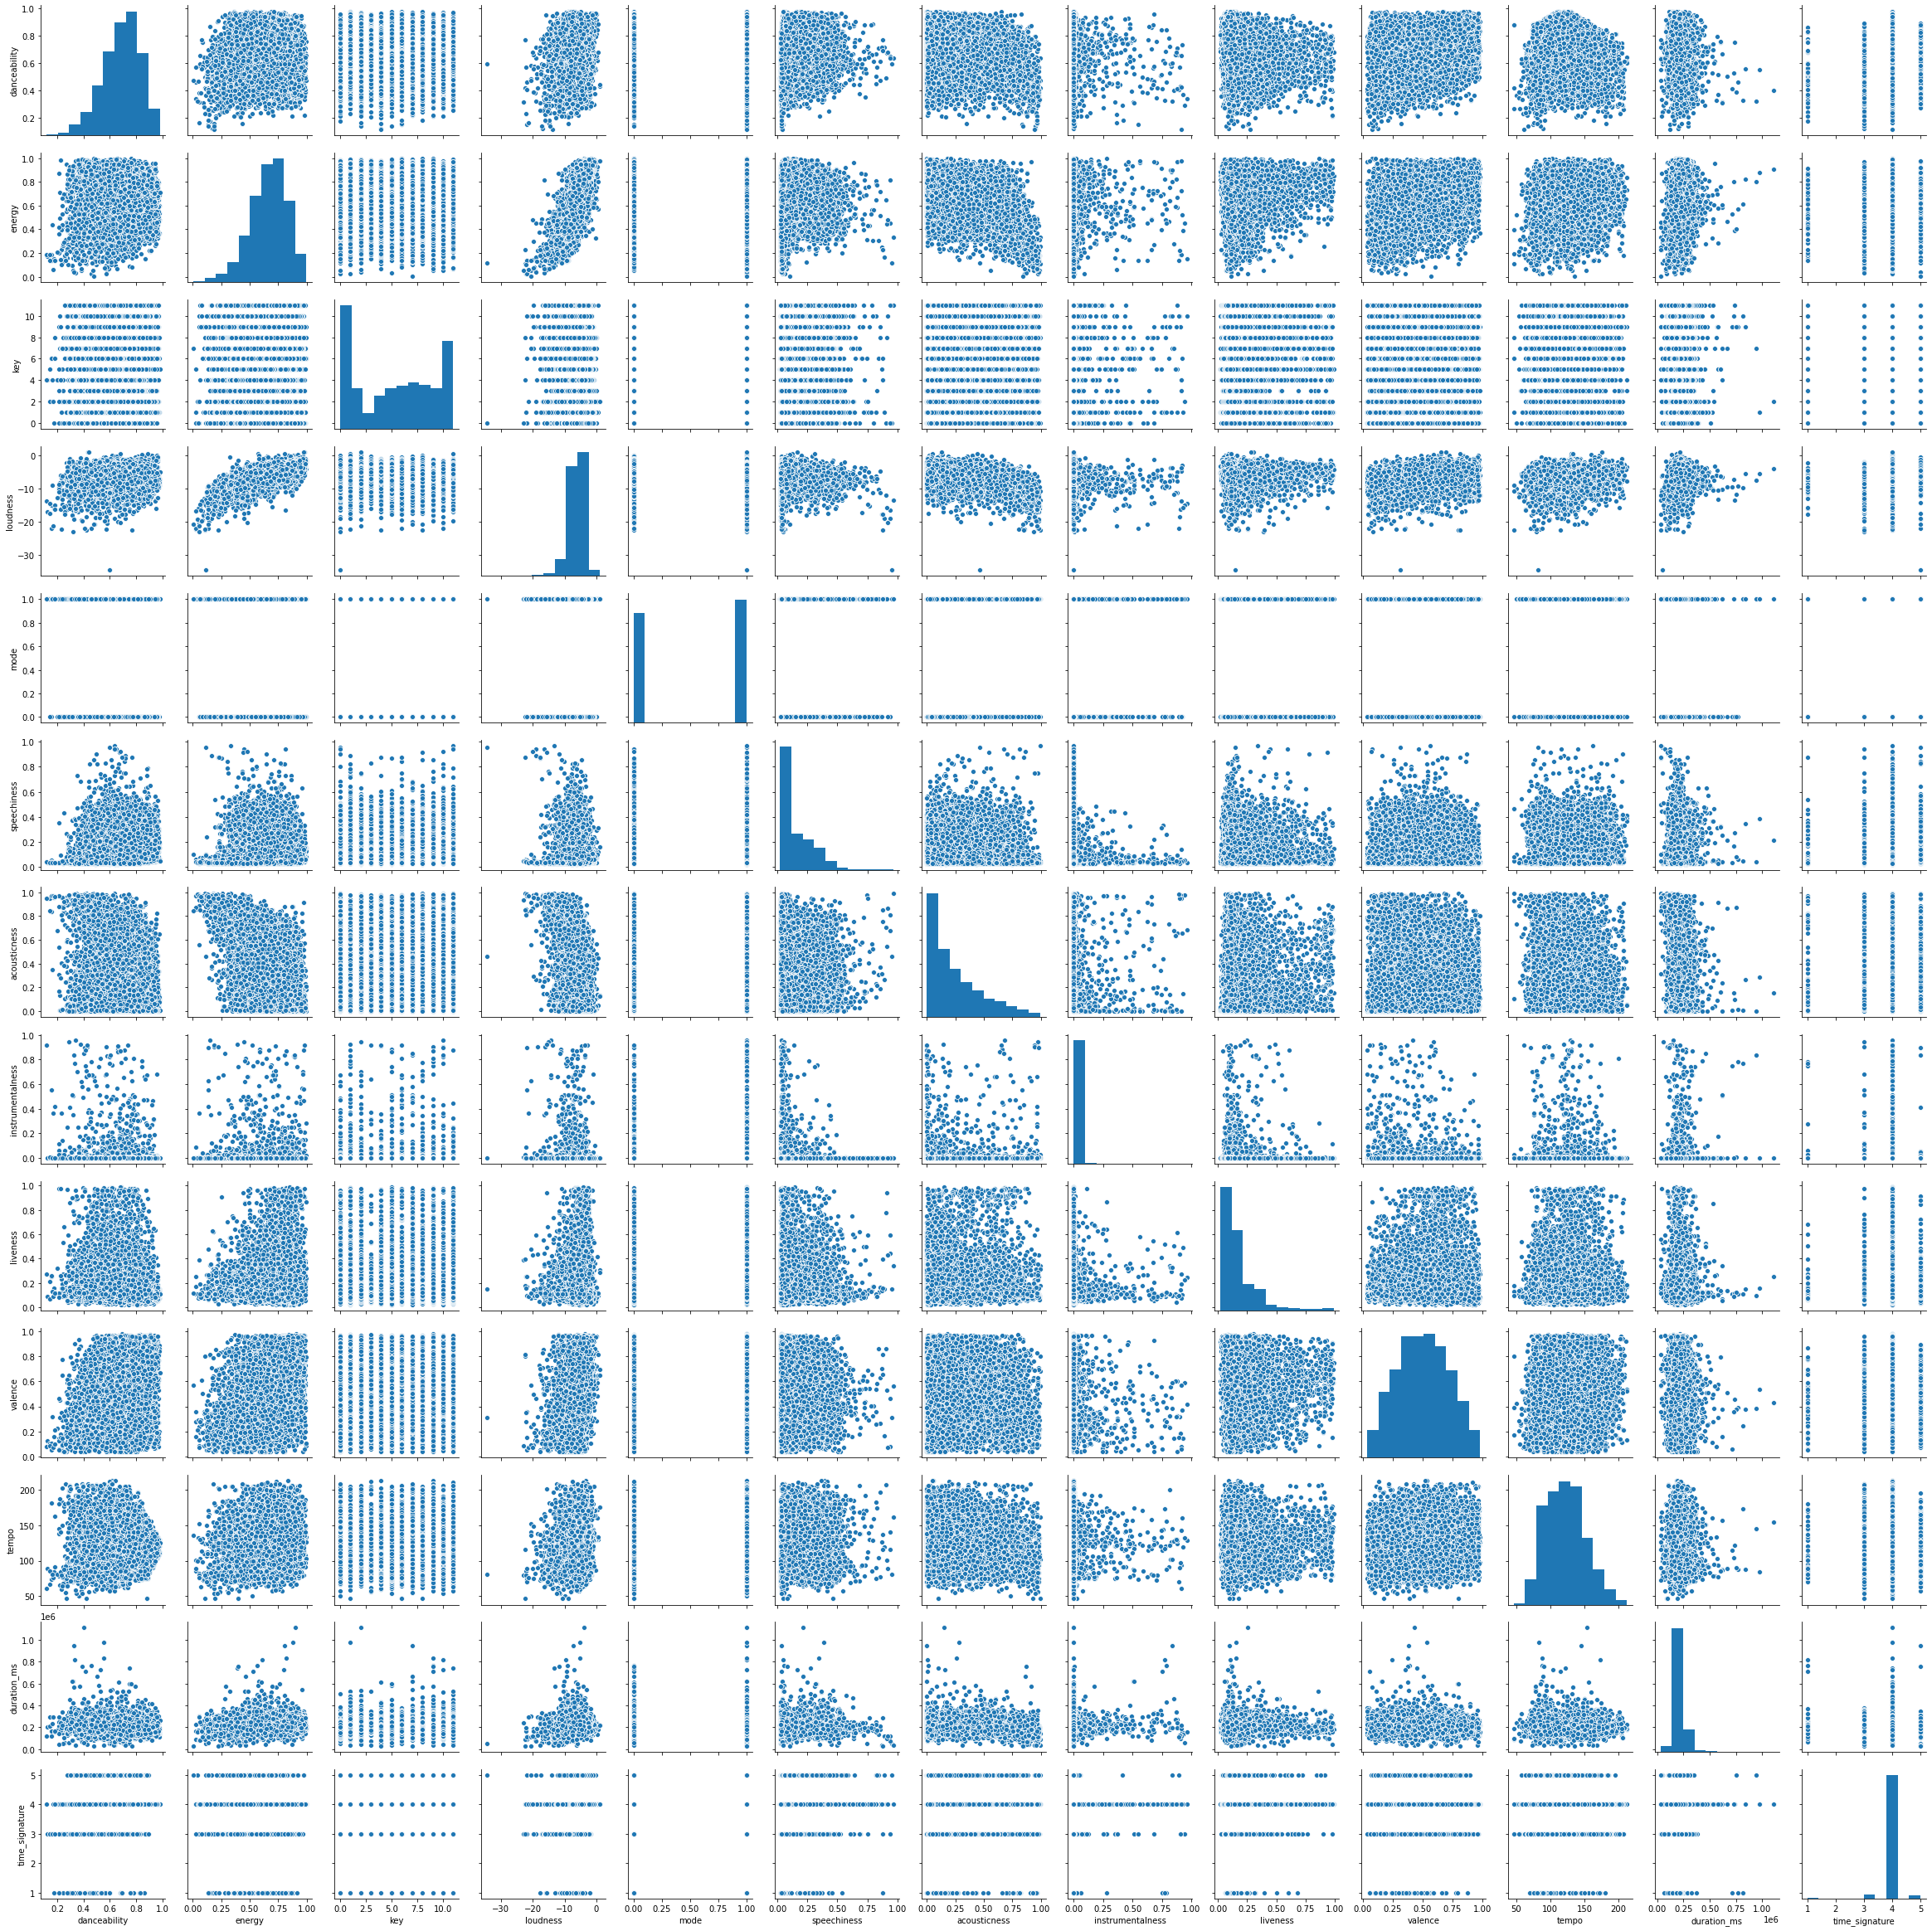

In [22]:
sns.pairplot(df)

## Questions


### Q1: Expore which Track Features Influence Valence

You will use inferential statistic methods to study how track features influence valence. You must find the best possible model for explaining the valence based on the features that you find significant.

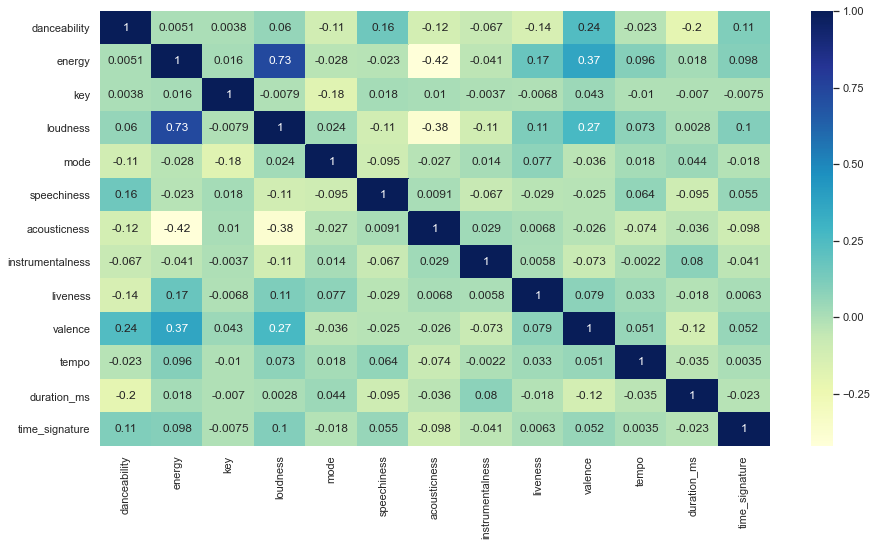

In [23]:
sns.set(rc = {'figure.figsize':(15,8)})  
# plotting correlation heatmap
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True,)
  
# displaying heatmap
plt.show()

* We observe that danceability, energy and loudness affect positively the track's valence and the duration of a track negatively.

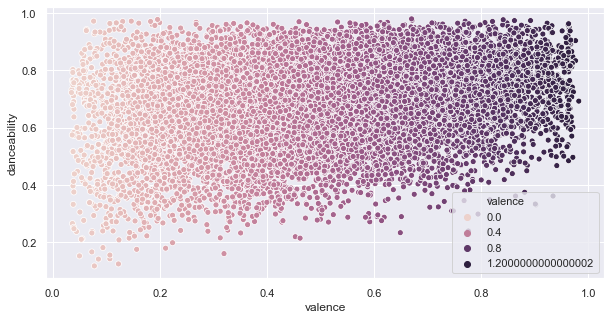

In [24]:
#Lets plot valence against danceability
sns.set(rc={'figure.figsize':(10,5)})
sns.scatterplot(data = df, x = 'valence', y = 'danceability', hue = 'valence')

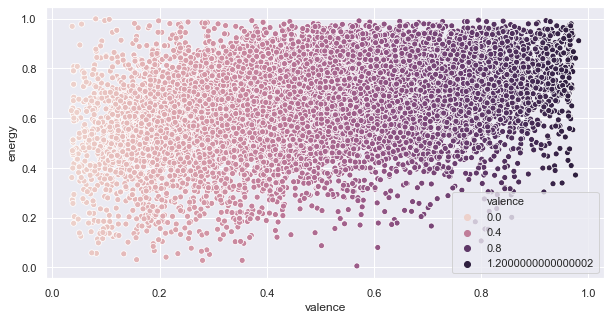

In [25]:
sns.set(rc={'figure.figsize':(10,5)})
sns.scatterplot(data = df, x = 'valence', y = 'energy', hue = 'valence')

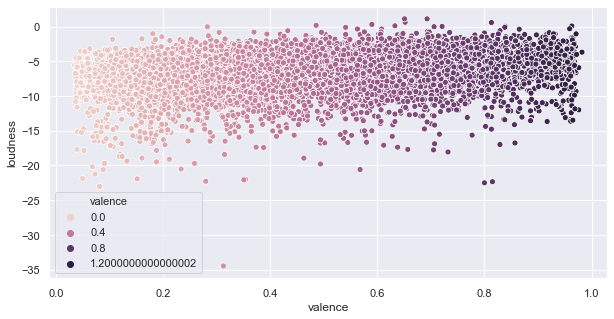

In [26]:
sns.set(rc={'figure.figsize':(10,5)})
sns.scatterplot(data = df, x = 'valence', y = 'loudness', hue = 'valence')

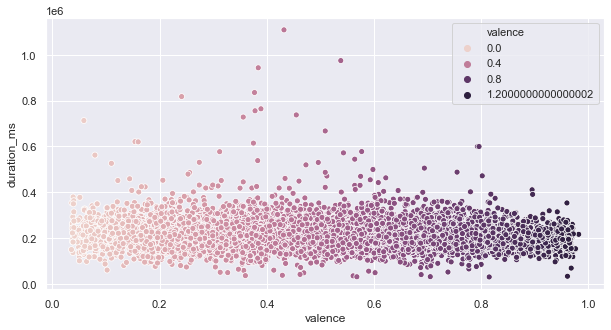

In [27]:
sns.set(rc={'figure.figsize':(10,5)})
sns.scatterplot(data = df, x = 'valence', y = 'duration_ms', hue = 'valence')

* So, we create a linear regression with all our variables 

In [28]:
mod = smf.ols("valence ~ acousticness + danceability + energy + instrumentalness + key + liveness + loudness + mode + speechiness + tempo + time_signature + duration_ms ", data=df)
valence_res = mod.fit()
valence_res.params

Intercept          -2.069913e-01
acousticness        1.733685e-01
danceability        3.996580e-01
energy              6.025531e-01
instrumentalness   -1.586655e-01
key                 2.158179e-03
liveness            4.871240e-02
loudness           -2.370475e-03
mode                5.382565e-03
speechiness        -1.173049e-01
tempo               2.285587e-04
time_signature      1.174830e-03
duration_ms        -2.897085e-07
dtype: float64

In [29]:
valence_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     357.4
Date:                Sun, 09 Jan 2022   Prob (F-statistic):               0.00
Time:                        11:29:12   Log-Likelihood:                 3542.2
No. Observations:               13880   AIC:                            -7058.
Df Residuals:                   13867   BIC:                            -6960.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.2070      0.030     -6.885      0.000      -0.266      -0.148
acousticness         0.1734      0.008     22.446      0.000       0.158       0.189
danceability         0.3997      0.012     33.271      0.000       0.376       0.423
energy               0.6026      0.015     39.441      0.000       0.573       0.632
instrumentalness    -0.1587      0.027     -5.929      0.000      -0.211      -0.106
key                  0.0022      0.000      4.847      0.000       0.001       0.003
liveness             0.0487      0.011      4.538      0.000       0.028       0.070
loudness            -0.0024      0.001     -2.350      0.019      -0.004      -0.000
mode                 0.0054      0.003      1.634      0.102      -0.001       0.012
speechiness         -0.1173      0.013     -9.302      0.000      -0.142      -0.093
tempo                0.0002   5.72e-05      3.996      0.000       0.000       0.000
time_signature       0.0012      0.005      0.218      0.827      -0.009       0.012
duration_ms      -2.897e-07   3.27e-08     -8.861      0.000   -3.54e-07   -2.26e-07
==============================================================================
Omnibus:                      141.031   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.882
Skew:                           0.014   Prob(JB):                     3.04e-20
Kurtosis:                       2.607   Cond. No.                     4.25e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.25e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
print(valence_res.mse_model)

12.572648264352836


* And we observe that the $R^2$ value is low and the total mean squared error(MSE) for our regression is 12.57

[Text(0, 0.5, 'Residuals'), Text(0.5, 0, 'Fitted Values')]

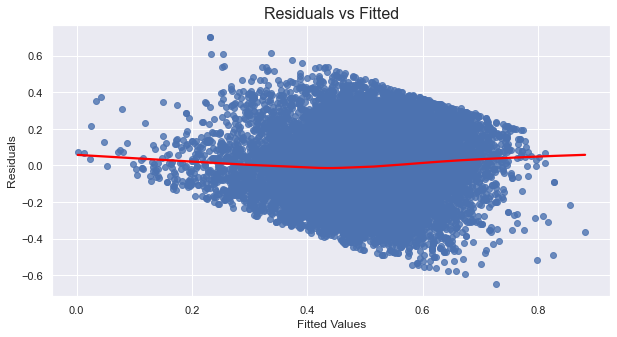

In [31]:
fitted_vals = valence_res.predict()
resids = valence_res.resid
resids_standardized = valence_res.get_influence().resid_studentized_internal
ax = sns.regplot(x=fitted_vals, y=resids, lowess=True, line_kws={'color': 'red'})
ax.set_title('Residuals vs Fitted', fontsize=16)
ax.set(xlabel='Fitted Values', ylabel='Residuals')

In [32]:
gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, valence_res.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])
gq_test

value
F statistic  0.973125
p-value      0.871525

* Checking heteroscedasticity : Using Goldfeld Quandt we test for heteroscedasticity.

* Null Hypothesis: Error terms are homoscedastic
* Alternative Hypothesis: Error terms are heteroscedastic.

* Since p value is bigger than 0.05 in Goldfeld Quandt Test, we can't reject it's null hypothesis that error terms are homoscedastic.

Anderson-Darling test ---- statistic: 7.4924, 5% critical value: 0.7870


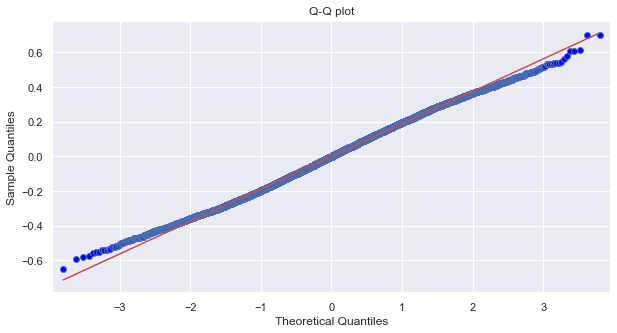

In [33]:
sm.ProbPlot(valence_res.resid).qqplot(line='s');
plt.title('Q-Q plot');
    
ad = stats.anderson(valence_res.resid, dist='norm')  
print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')

------

* So we create dummy variables for our categorical columns

In [34]:
f_df =  pd.get_dummies(data=df, columns=['key', 'mode', 'time_signature'],drop_first=True)

In [35]:
f_df.columns

Index(['song_id', 'song_name', 'artist', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'mode_1', 'time_signature_3', 'time_signature_4', 'time_signature_5'],
      dtype='object')

In [36]:
mod = smf.ols("valence ~ acousticness + danceability + energy + instrumentalness + liveness + loudness + mode_1 + speechiness + tempo + time_signature_3 + time_signature_4  + time_signature_5 + duration_ms + key_1 + key_2 + key_3 + key_4 + key_5 + key_6 + key_7 +  key_8 + key_9 + key_10 + key_11", data=f_df)
valence_res = mod.fit()
valence_res.params

Intercept          -1.742686e-01
acousticness        1.706092e-01
danceability        4.152355e-01
energy              6.045316e-01
instrumentalness   -1.606384e-01
liveness            5.145896e-02
loudness           -2.348998e-03
mode_1              7.224846e-03
speechiness        -1.178238e-01
tempo               2.376387e-04
time_signature_3   -1.695406e-02
time_signature_4   -3.209745e-02
time_signature_5    5.220283e-03
duration_ms        -2.810159e-07
key_1              -2.518516e-02
key_2              -1.640257e-02
key_3               4.347195e-02
key_4              -3.254063e-02
key_5               1.695253e-02
key_6               1.311190e-02
key_7              -1.673555e-03
key_8               4.178061e-03
key_9               3.981845e-03
key_10             -4.720345e-03
key_11              1.817902e-02
dtype: float64

In [37]:
valence_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     184.4
Date:                Sun, 09 Jan 2022   Prob (F-statistic):               0.00
Time:                        11:29:40   Log-Likelihood:                 3596.1
No. Observations:               13880   AIC:                            -7142.
Df Residuals:                   13855   BIC:                            -6954.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.1743      0.033     -5.223      0.000      -0.240      -0.109
acousticness         0.1706      0.008     22.070      0.000       0.155       0.186
danceability         0.4152      0.012     33.472      0.000       0.391       0.440
energy               0.6045      0.015     39.585      0.000       0.575       0.634
instrumentalness    -0.1606      0.027     -6.017      0.000      -0.213      -0.108
liveness             0.0515      0.011      4.800      0.000       0.030       0.072
loudness            -0.0023      0.001     -2.334      0.020      -0.004      -0.000
mode_1               0.0072      0.003      2.126      0.033       0.001       0.014
speechiness         -0.1178      0.013     -9.191      0.000      -0.143      -0.093
tempo                0.0002   5.71e-05      4.162      0.000       0.000       0.000
time_signature_3    -0.0170      0.027     -0.623      0.533      -0.070       0.036
time_signature_4    -0.0321      0.026     -1.237      0.216      -0.083       0.019
time_signature_5     0.0052      0.028      0.188      0.851      -0.049       0.060
duration_ms       -2.81e-07   3.27e-08     -8.602      0.000   -3.45e-07   -2.17e-07
key_1               -0.0252      0.007     -3.808      0.000      -0.038      -0.012
key_2               -0.0164      0.008     -2.181      0.029      -0.031      -0.002
key_3                0.0435      0.010      4.152      0.000       0.023       0.064
key_4               -0.0325      0.008     -4.027      0.000      -0.048      -0.017
key_5                0.0170      0.008      2.230      0.026       0.002       0.032
key_6                0.0131      0.007      1.751      0.080      -0.002       0.028
key_7               -0.0017      0.007     -0.231      0.818      -0.016       0.013
key_8                0.0042      0.007      0.567      0.570      -0.010       0.019
key_9                0.0040      0.008      0.526      0.599      -0.011       0.019
key_10              -0.0047      0.008     -0.623      0.533      -0.020       0.010
key_11               0.0182      0.007      2.468      0.014       0.004       0.033
==============================================================================
Omnibus:                      137.348   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.008
Skew:                           0.013   Prob(JB):                     7.75e-20
Kurtosis:                       2.611   Cond. No.                     7.14e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.14e+06. This might indicate that there are
strong multicollinearity or other numerical probl

In [38]:
print(valence_res.mse_total)

0.04601802472538675


* Now, we have a better regression line as the mse is now 0.046 and the $R^2$ has increased(but this does not necessarily means we have a better model). So, in both cases we should check the adjusted $R^2$

In [39]:
mean_absolute_error(f_df['valence'],valence_res.fittedvalues)

0.15228317606554606

* We calculate the mean absolute error, and we print the first 5 values of our predictions and the actual values.

In [40]:
print(valence_res.fittedvalues[:5],f_df['valence'][:5])

0       0.438833
428     0.593438
809     0.471662
1587    0.378096
2041    0.571811
dtype: float64 0       0.5350
428     0.7420
809     0.6610
1587    0.0862
2041    0.7170
Name: valence, dtype: float64


----

* Methods for stepwise selection of features

In [41]:
def process_subset(y, data, feature_set):
    X = data.loc[:, feature_set].values
    X = sm.add_constant(X)
    names = ['intercept']
    names.extend(feature_set)
    model = sm.OLS(y, X)
    model.data.xnames = names
    regr = model.fit()
    return regr

In [42]:
def get_best_of_k(y, data, k):
    
    best_rsquared = 0
    best_model = None
    for comb in itertools.combinations(data.columns, k):
        regr = process_subset(y, data, comb)
        if regr.rsquared > best_rsquared:
            best_rsquared = regr.rsquared
            best_model = regr

    return best_model

In [43]:
def forward_add_variable(data, exog, selected, to_select):
    best_rsquared = 0
    best_model = None
    best_column = None
    y = data.loc[:, exog]
    
    for column in to_select:
        new_selected = selected + [column]
        regr = process_subset(y, data, new_selected)
        if regr.rsquared > best_rsquared:
            best_rsquared = regr.rsquared
            best_model = regr
            best_column = column
    
    return best_model, best_column

In [44]:
def forward_stepwise_selection(data, exog):

    best_models = []
    best_model = None
    selected = []
    to_select = [ x for x in data.columns if x != exog ]

    p = len(to_select) + 1
    for i in range(1, p):
        print(f'Finding the best model for {i} variable{"s" if i > 1 else ""}')
        model, best_column = forward_add_variable(data, exog, selected, to_select)
        selected.append(best_column)
        to_select.remove(best_column)
        if not best_model or model.rsquared_adj > best_model.rsquared_adj:
            best_model = model
        print(selected)
        best_models.append(model)
        
    print(f'Fitted {1 + p*(p+1)//2} models')
    return best_model, best_models

In [45]:
best_model, _ = forward_stepwise_selection(f_df.iloc[:, 3:], 'valence')
print('Best overall model:', len(best_model.model.exog_names), best_model.model.exog_names)

Finding the best model for 1 variable
['energy']
Finding the best model for 2 variables
['energy', 'danceability']
Finding the best model for 3 variables
['energy', 'danceability', 'acousticness']
Finding the best model for 4 variables
['energy', 'danceability', 'acousticness', 'duration_ms']
Finding the best model for 5 variables
['energy', 'danceability', 'acousticness', 'duration_ms', 'speechiness']
Finding the best model for 6 variables
['energy', 'danceability', 'acousticness', 'duration_ms', 'speechiness', 'key_1']
Finding the best model for 7 variables
['energy', 'danceability', 'acousticness', 'duration_ms', 'speechiness', 'key_1', 'key_4']
Finding the best model for 8 variables
['energy', 'danceability', 'acousticness', 'duration_ms', 'speechiness', 'key_1', 'key_4', 'instrumentalness']
Finding the best model for 9 variables
['energy', 'danceability', 'acousticness', 'duration_ms', 'speechiness', 'key_1', 'key_4', 'instrumentalness', 'liveness']
Finding the best model for 10 v

* We run our regression with 20 features, as we find from our stepwise selection

In [46]:
mod = smf.ols("valence ~ acousticness + danceability + energy + instrumentalness + liveness + loudness + mode_1 + speechiness + tempo + time_signature_3 + time_signature_4 + duration_ms + key_1 + key_2 + key_3 + key_4 + key_5 + key_6 + key_11", data=f_df)
valence_res = mod.fit()
valence_res.params

Intercept          -1.700892e-01
acousticness        1.705895e-01
danceability        4.151134e-01
energy              6.047029e-01
instrumentalness   -1.608425e-01
liveness            5.136345e-02
loudness           -2.355300e-03
mode_1              7.656510e-03
speechiness        -1.177053e-01
tempo               2.378312e-04
time_signature_3   -2.096901e-02
time_signature_4   -3.632437e-02
duration_ms        -2.808851e-07
key_1              -2.554071e-02
key_2              -1.677202e-02
key_3               4.319769e-02
key_4              -3.274965e-02
key_5               1.672201e-02
key_6               1.285909e-02
key_11              1.797001e-02
dtype: float64

In [47]:
valence_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     232.9
Date:                Sun, 09 Jan 2022   Prob (F-statistic):               0.00
Time:                        11:29:42   Log-Likelihood:                 3595.2
No. Observations:               13880   AIC:                            -7150.
Df Residuals:                   13860   BIC:                            -7000.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.1701      0.023     -7.464      0.000      -0.215      -0.125
acousticness         0.1706      0.008     22.082      0.000       0.155       0.186
danceability         0.4151      0.012     33.481      0.000       0.391       0.439
energy               0.6047      0.015     39.622      0.000       0.575       0.635
instrumentalness    -0.1608      0.027     -6.029      0.000      -0.213      -0.109
liveness             0.0514      0.011      4.794      0.000       0.030       0.072
loudness            -0.0024      0.001     -2.342      0.019      -0.004      -0.000
mode_1               0.0077      0.003      2.292      0.022       0.001       0.014
speechiness         -0.1177      0.013     -9.198      0.000      -0.143      -0.093
tempo                0.0002   5.71e-05      4.166      0.000       0.000       0.000
time_signature_3    -0.0210      0.013     -1.592      0.111      -0.047       0.005
time_signature_4    -0.0363      0.010     -3.603      0.000      -0.056      -0.017
duration_ms      -2.809e-07   3.26e-08     -8.605      0.000   -3.45e-07   -2.17e-07
key_1               -0.0255      0.005     -5.149      0.000      -0.035      -0.016
key_2               -0.0168      0.006     -2.732      0.006      -0.029      -0.005
key_3                0.0432      0.009      4.548      0.000       0.025       0.062
key_4               -0.0327      0.007     -4.848      0.000      -0.046      -0.020
key_5                0.0167      0.006      2.706      0.007       0.005       0.029
key_6                0.0129      0.006      2.130      0.033       0.001       0.025
key_11               0.0180      0.006      3.056      0.002       0.006       0.029
==============================================================================
Omnibus:                      136.562   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.641
Skew:                           0.014   Prob(JB):                     9.31e-20
Kurtosis:                       2.612   Cond. No.                     3.66e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.66e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
valence_res.mse_total

0.04601802472538675

In [49]:
vif_data = pd.DataFrame()
vif_data["feature"] = f_df.iloc[:, 3:].columns
vif_data["VIF"] = [variance_inflation_factor(f_df.iloc[:, 3:].values, i) for i in range(len(f_df.iloc[:, 3:].columns))]

In [50]:
vif_data

feature         VIF
0       danceability   29.789178
1             energy   39.754611
2           loudness   15.109850
3        speechiness    2.676926
4       acousticness    2.771095
5   instrumentalness    1.053401
6           liveness    2.589142
7            valence    8.574698
8              tempo   19.640852
9        duration_ms   17.927978
10             key_1    2.365074
11             key_2    1.775883
12             key_3    1.299907
13             key_4    1.648843
14             key_5    1.786721
15             key_6    1.818459
16             key_7    1.876082
17             key_8    1.836611
18             key_9    1.769831
19            key_10    1.827428
20            key_11    1.895193
21            mode_1    2.389308
22  time_signature_3    4.569407
23  time_signature_4  112.831237
24  time_signature_5    3.465255

##### Linear regression assumptions

* We should check if our residuals' mean is equal to 0

In [51]:
valence_res.resid.mean()

-1.5594926466903332e-11

* Residuals VS Fitted values

[Text(0, 0.5, 'Residuals'), Text(0.5, 0, 'Fitted Values')]

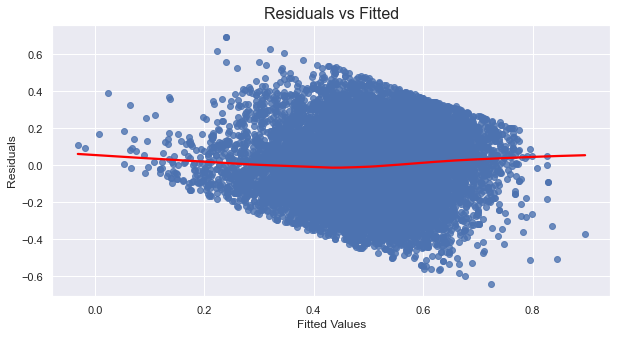

In [52]:
fitted_vals = valence_res.predict()
resids = valence_res.resid
resids_standardized = valence_res.get_influence().resid_studentized_internal
ax = sns.regplot(x=fitted_vals, y=resids, lowess=True, line_kws={'color': 'red'})
ax.set_title('Residuals vs Fitted', fontsize=16)
ax.set(xlabel='Fitted Values', ylabel='Residuals')

* Homoscedasticity (equal variance) of residuals check

In [53]:
gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, valence_res.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])
gq_test

value
F statistic  0.973166
p-value      0.871039

* Residuals normality check

Anderson-Darling test ---- statistic: 7.5869, 5% critical value: 0.7870


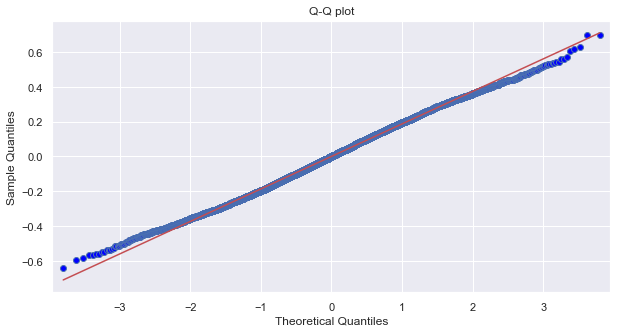

In [54]:
sm.ProbPlot(valence_res.resid).qqplot(line='s');
plt.title('Q-Q plot');
    
ad = stats.anderson(valence_res.resid, dist='norm')  
print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')

### Q2: Predict Valence

Use Machine Learning techniques to predict valence based on track features:

* You will use at least three different methods. For each methods you should ensure that you tune your hyperparameters as best as you can.

* Once you identify the best method and hyperparameters, explain, to the extent that is possible, which features influence the valence metric.

* You will evaluate your predictions on a holdout 20% testing dataset.

In [55]:
f_df

song_id  \
0       5aAx2yezTd8zXrkmtKl66Z   
428     5knuzwU65gJK7IF5yJsuaW   
809     7BKLCZ1jbUBVqRi2FVlTVw   
1587    3NdDpSvN911VPGivFlV5d0   
2041    78rIJddV4X0HkNAInEcYde   
...                        ...   
273595  3aQV6E290SJvasp2VOgvBz   
273596  43YQDj1KOPMFAUcTEPKy4p   
273597  1985nAkGJf1oOrgHCWftoN   
273598  7ntUbTIwmwOD6ygCMRZT6e   
273599  5BJMeoCXXgbRAWfp6fTulr   

                                                song_name            artist  \
0                                                 Starboy        The Weeknd   
428               Rockabye (feat. Sean Paul & Anne-Marie)      Clean Bandit   
809                                                Closer  The Chainsmokers   
1587    I Don’t Wanna Live Forever (Fifty Shades Darke...              ZAYN   
2041              Call On Me - Ryan Riback Extended Remix           Starley   
...                                                   ...               ...   
273595                 What I Please (feat. Denzel Curry)        Smokepurpp   
273596                                           Millions        Young Thug   
273597                                             Matrix        NLE Choppa   
273598  Writing on the Wall (feat. Post Malone, Cardi ...    French Montana   
273599               Shotta Flow (feat. Blueface) [Remix]        NLE Choppa   

        danceability  energy  loudness  speechiness  acousticness  \
0              0.681   0.594    -7.028       0.2820       0.16500   
428            0.720   0.763    -4.068       0.0523       0.40600   
809            0.748   0.524    -5.599       0.0338       0.41400   
1587           0.735   0.451    -8.374       0.0585       0.06310   
2041           0.670   0.838    -4.031       0.0362       0.06040   
...              ...     ...       ...          ...           ...   
273595         0.810   0.690    -7.841       0.2700       0.03730   
273596         0.942   0.531    -7.510       0.2150       0.00236   
273597         0.762   0.679    -7.595       0.1920       0.04260   
273598         0.774   0.836    -2.323       0.1520       0.28800   
273599         0.894   0.511    -4.768       0.4210       0.02510   

        instrumentalness  liveness  ...  key_6  key_7  key_8  key_9  key_10  \
0               0.000003    0.1340  ...      0      1      0      0       0   
428             0.000000    0.1800  ...      0      0      0      1       0   
809             0.000000    0.1110  ...      0      0      1      0       0   
1587            0.000013    0.3250  ...      0      0      0      0       0   
2041            0.000611    0.1590  ...      0      0      0      0       0   
...                  ...       ...  ...    ...    ...    ...    ...     ...   
273595          0.000000    0.1060  ...      0      0      0      0       1   
273596          0.000106    0.0812  ...      0      0      0      0       0   
273597          0.000000    0.1860  ...      0      0      0      0       0   
273598          0.000024    0.0824  ...      0      0      0      1       0   
273599          0.000000    0.1400  ...      0      0      0      0       0   

        key_11  mode_1  time_signature_3  time_signature_4  time_signature_5  
0            0       1                 0                 1                 0  
428          0       0                 0                 1                 0  
809          0       1                 0                 1                 0  
1587         0       1                 0                 1                 0  
2041         0       1                 0                 1                 0  
...        ...     ...               ...               ...               ...  
273595       0       0                 0                 1                 0  
273596       0       1                 0                 1                 0  
273597       0       0                 0                 1                 0  
273598       0       0                 0                 1                 0  
273599       0    

####  RandomForest

In [162]:
df_train = f_df[['danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness','tempo', 'duration_ms', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'mode_1', 'time_signature_3', 'time_signature_4', 'time_signature_5']]

In [163]:
f_df.columns

Index(['song_id', 'song_name', 'artist', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'mode_1', 'time_signature_3', 'time_signature_4', 'time_signature_5'],
      dtype='object')

In [164]:
X = np.array(df_train)

y = f_df['valence']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,shuffle=True)

In [165]:
clf = RandomForestRegressor(n_jobs=-1, random_state=0,n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [166]:
mean_squared_error(y_test, y_pred)

0.028333357694754327

In [167]:
mean_absolute_error(y_test, y_pred)

0.13259235839797334

In [62]:
clf.feature_importances_

array([0.15020589, 0.20354252, 0.07751639, 0.09100424, 0.10071836,
       0.04775948, 0.08788766, 0.08632185, 0.08670934, 0.00667626,
       0.00567782, 0.00317878, 0.00530735, 0.00439995, 0.00512217,
       0.00453553, 0.0061363 , 0.00439785, 0.00339917, 0.00581078,
       0.00962873, 0.00125199, 0.00178898, 0.00102261])

* We run a random forest regressor without tuning any hyperparameters, and we observe that the mean squared error is 0.028333 (less than the linear's regression), also less is the mean absolute error

* So if we try to finetune our model, may the results will be better,and for this purpose we create a dict with different values of our hyperparamaters.


In [63]:
parameters = {'n_estimators': [200, 400,1000], 'max_depth': [5,10,25],
             'bootstrap': [True, False],'min_samples_split': [2, 5, 10],}
clf_cv = RandomizedSearchCV(clf, parameters, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error',random_state=42)
clf_cv.fit(X_train, y_train)
y_pred = clf_cv.best_estimator_.predict(X_test)

In [64]:
clf_cv.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'max_depth': 25,
 'bootstrap': True}

* And we find our best hyperparams, so we can now create our model with these params.

In [65]:
clf_f = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators= 400,min_samples_split= 2,max_depth= 25,bootstrap= True)
clf_f.fit(X_train, y_train)
y_pred = clf_f.predict(X_test)

In [66]:
r2_score(y_test, y_pred)

0.3971813009929158

In [67]:
mean_squared_error(y_test, y_pred)

0.028034167227266343

In [68]:
mean_absolute_error(y_test, y_pred)

0.1323840078037106

* And we observe a small improvement in our scores, as for the $R^2$ we observe that now is 0.397(improvement in contrast with linear regression)

* So we can see our feature importance and we observe that the most important feature for our model is the energy, following by the track's danceability, acousticness, speechiness and liveness.

In [69]:
indices = np.argsort(clf_f.feature_importances_)[::-1]
print("Feature ranking:")
features=['danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness','tempo', 'duration_ms', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'mode_1', 'time_signature_3', 'time_signature_4', 'time_signature_5']
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, features[indices[f]], clf_f.feature_importances_[indices[f]]))

Feature ranking:
1. feature energy (0.206816)
2. feature danceability (0.144163)
3. feature acousticness (0.097102)
4. feature speechiness (0.089574)
5. feature liveness (0.089372)
6. feature tempo (0.088258)
7. feature duration_ms (0.087865)
8. feature loudness (0.078147)
9. feature instrumentalness (0.048448)
10. feature mode_1 (0.009773)
11. feature key_1 (0.007069)
12. feature key_11 (0.006183)
13. feature key_8 (0.005675)
14. feature key_2 (0.005478)
15. feature key_6 (0.005342)
16. feature key_5 (0.004969)
17. feature key_4 (0.004925)
18. feature key_7 (0.004442)
19. feature key_9 (0.004431)
20. feature key_10 (0.004425)
21. feature key_3 (0.003000)
22. feature time_signature_4 (0.001985)
23. feature time_signature_5 (0.001316)
24. feature time_signature_3 (0.001242)


In [70]:
clf_f.estimators_[0]

DecisionTreeRegressor(criterion='mse', max_depth=25, max_features='auto',
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=209652396, splitter='best')

* Plotting the first estimator tree and also saving it into a png file.

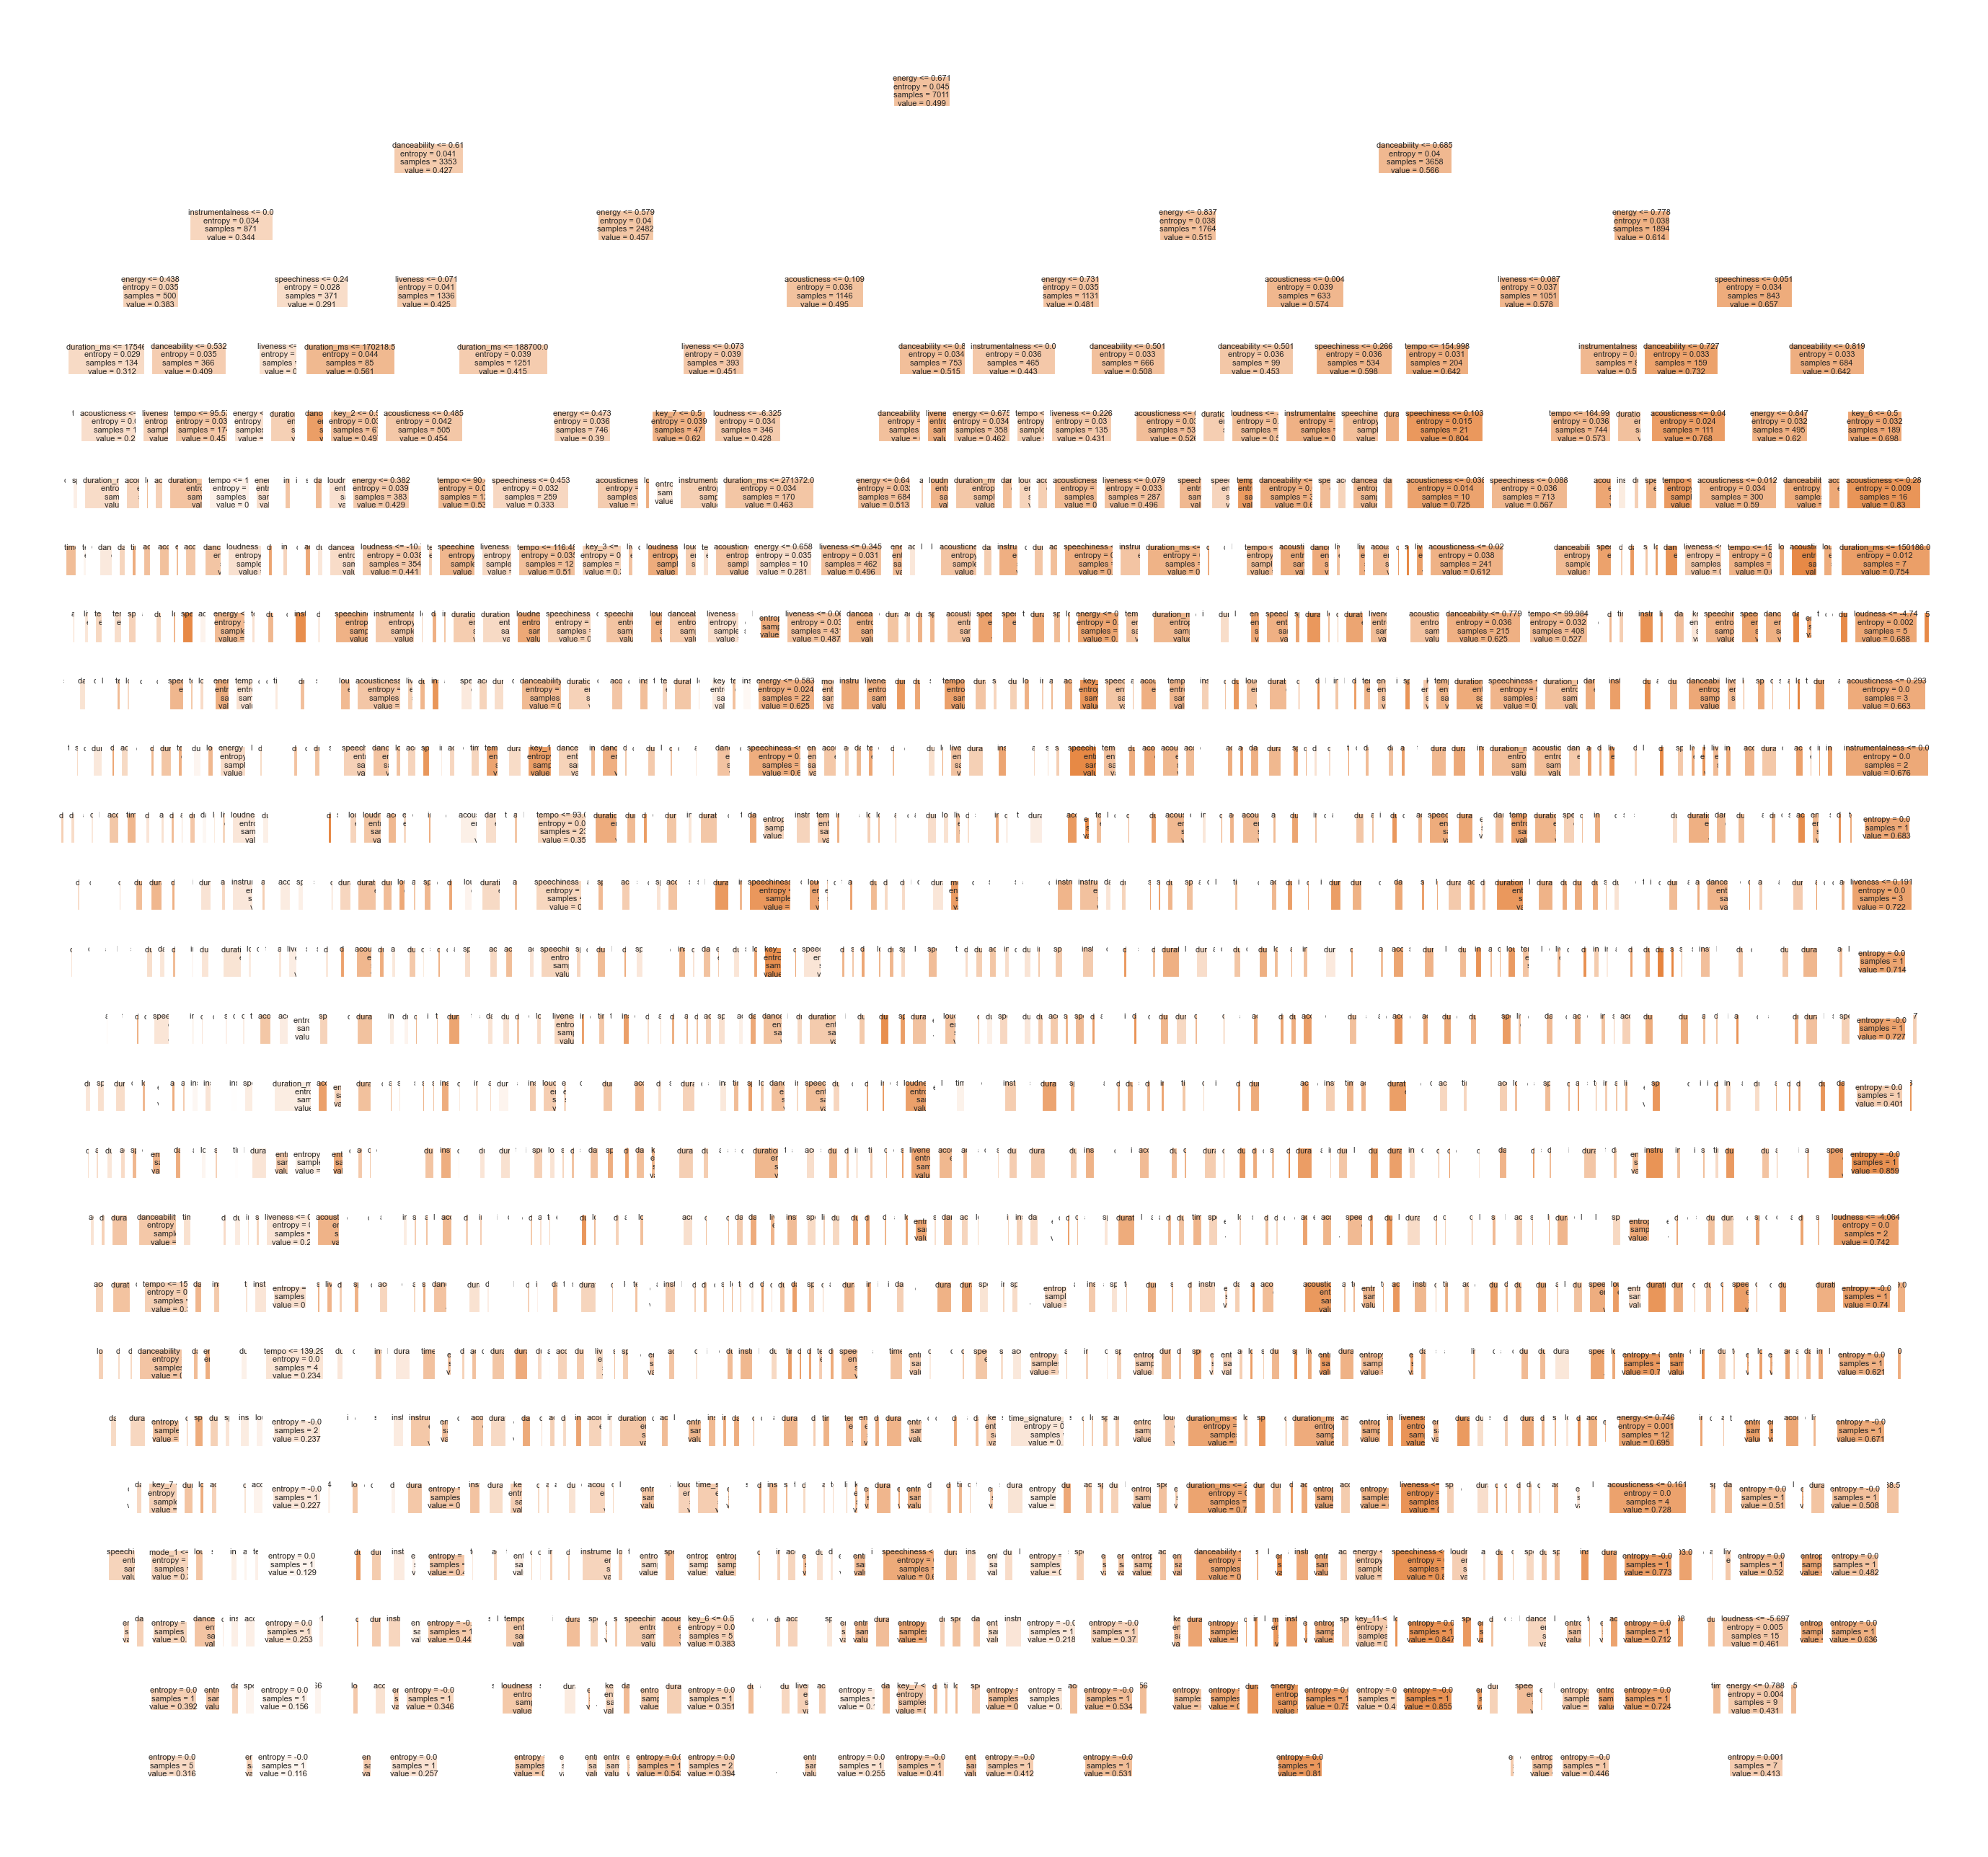

In [71]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(clf_f.estimators_[0],
               feature_names = features,
               filled = True);
fig.savefig('rf_individualtree.png')

##### Using month

* According to a Economist's article (https://www.economist.com/graphic-detail/2020/02/08/data-from-spotify-suggest-that-listeners-are-gloomiest-in-february) the most popular tunes in February will be depressing ones and the happier ones will be in December. So, we will use as a feature the month that a track was on the most populars in order to predict the track's valence

* In order to check this, we will use the same procedure as above.

In [72]:
f_df1 = f_df.copy()

In [73]:
f_df1['month'] = month

In [74]:
f_df1 =  pd.get_dummies(data=f_df1, columns=['month'],drop_first=True)

In [75]:
f_df1.columns

Index(['song_id', 'song_name', 'artist', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'mode_1', 'time_signature_3', 'time_signature_4', 'time_signature_5',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')

In [76]:
df_train = f_df1[['danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness','tempo', 'duration_ms', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'mode_1', 'time_signature_3', 'time_signature_4', 'time_signature_5','month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12']]

In [77]:
X = np.array(df_train)

y = f_df1['valence']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,shuffle=True)

In [78]:
clf_f = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators= 400,min_samples_split= 2,max_depth= 25,bootstrap= True)
clf_f.fit(X_train, y_train)
y_pred = clf_f.predict(X_test)

In [79]:
r2_score(y_test, y_pred)

0.39200088024047686

In [80]:
mean_squared_error(y_test, y_pred)

0.028275083413046055

In [81]:
mean_absolute_error(y_test, y_pred)

0.13368968564625353

In [82]:
indices = np.argsort(clf_f.feature_importances_)[::-1]
print("Feature ranking:")
features=['danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness','tempo', 'duration_ms', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'mode_1', 'time_signature_3', 'time_signature_4', 'time_signature_5','month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12']
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, features[indices[f]], clf_f.feature_importances_[indices[f]]))

Feature ranking:
1. feature energy (0.202565)
2. feature danceability (0.139802)
3. feature acousticness (0.092275)
4. feature speechiness (0.085016)
5. feature liveness (0.084685)
6. feature tempo (0.083109)
7. feature duration_ms (0.082977)
8. feature loudness (0.073060)
9. feature instrumentalness (0.046204)
10. feature mode_1 (0.009166)
11. feature month_12 (0.007120)
12. feature key_1 (0.006515)
13. feature key_11 (0.005633)
14. feature key_8 (0.005102)
15. feature key_2 (0.004987)
16. feature key_6 (0.004837)
17. feature key_5 (0.004537)
18. feature month_6 (0.004513)
19. feature key_4 (0.004508)
20. feature month_9 (0.004454)
21. feature month_11 (0.004400)
22. feature key_7 (0.003988)
23. feature key_10 (0.003954)
24. feature key_9 (0.003920)
25. feature month_4 (0.003901)
26. feature month_5 (0.003856)
27. feature month_10 (0.003759)
28. feature month_8 (0.003691)
29. feature month_3 (0.003627)
30. feature month_2 (0.003522)
31. feature month_7 (0.003368)
32. feature key_3 (0.

* We observe that the results of our model have not been improved(so does for all our models(XGBoost,NN),not showing in this notebook) so we reject this feature. But we can see that the December has more influence in valence in contrast with the other months.

#### XGB

* Now we will try to predict the tracks' valence with XGBoost Regressor

In [83]:
model = XGBRegressor(n_estimators=1000, max_depth=10, eta=0.1, subsample=0.8, colsample_bytree=0.8)

In [84]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1,scoring='neg_mean_absolute_error')

In [85]:
scores

array([-0.12683288, -0.12651078, -0.12531225, -0.13082447, -0.13537114,
       -0.12372924, -0.13122993, -0.12301123, -0.12666912, -0.1309162 ,
       -0.13075989, -0.13058471, -0.12617704, -0.12897501, -0.12711519,
       -0.12778756, -0.12567902, -0.13210221, -0.13245328, -0.12845064,
       -0.1263754 , -0.12550991, -0.12750098, -0.13056044, -0.12790281,
       -0.12741795, -0.12559339, -0.13178831, -0.13201217, -0.12968063])

In [86]:
print(-np.mean(scores))

0.12849445889528072


In [87]:
model.fit(X_train, y_train)

[11:52:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

In [88]:
y_pred = model.predict(X_test)

In [89]:
mean_squared_error(y_test, y_pred)

0.028408799307800107

In [90]:
mean_absolute_error(y_test, y_pred)

0.12943777782673108

* As we can observe the mean squared error is now 0.02840 and the mean absolute error is now 0.12943

In [91]:
r2_score(y_test, y_pred)

0.3891255873502423

* Also we have a good $R^2$ value.

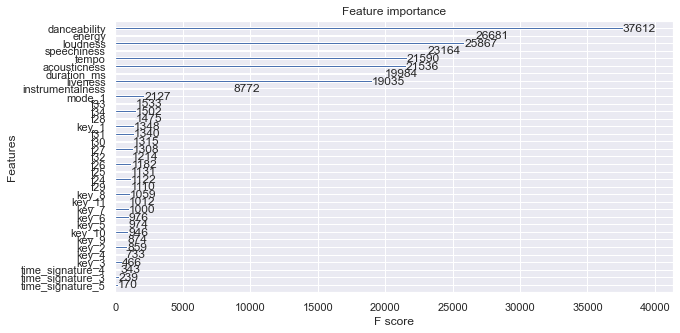

In [92]:
model.get_booster().feature_names = ['danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness','tempo', 'duration_ms', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'mode_1', 'time_signature_3', 'time_signature_4', 'time_signature_5']
plot_importance(model.get_booster())

* We can observe again that the four more significant features are the danceability, the energy, the loudness and the speechiness.This confirms our initial prediction that the valence of a track is affected mainly from these four variables.

* But in comparison with Random Forest model, now we have danceability as most important than the energy we had in the above model. Also by this plot we can see that the tempo seems to be significant in this model.

-----------

##### Delete upper and lower 0.015 quantile(Quantile based flooring and capping)

In [93]:
df_train = f_df[['danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness','tempo', 'duration_ms', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'mode_1', 'time_signature_3', 'time_signature_4', 'time_signature_5','valence']]

In [94]:
q_low = df_train["valence"].quantile(0.015)
q_hi  = df_train["valence"].quantile(0.985)

df_filtered = df_train[(df_train["valence"] < q_hi) & (df_train["valence"] > q_low)]

In [95]:
df_filtered

danceability  energy  loudness  speechiness  acousticness  \
0              0.681   0.594    -7.028       0.2820       0.16500   
428            0.720   0.763    -4.068       0.0523       0.40600   
809            0.748   0.524    -5.599       0.0338       0.41400   
2041           0.670   0.838    -4.031       0.0362       0.06040   
2360           0.773   0.819    -5.946       0.1180       0.42600   
...              ...     ...       ...          ...           ...   
273595         0.810   0.690    -7.841       0.2700       0.03730   
273596         0.942   0.531    -7.510       0.2150       0.00236   
273597         0.762   0.679    -7.595       0.1920       0.04260   
273598         0.774   0.836    -2.323       0.1520       0.28800   
273599         0.894   0.511    -4.768       0.4210       0.02510   

        instrumentalness  liveness    tempo  duration_ms  key_1  ...  key_7  \
0               0.000003    0.1340  186.054       230453      0  ...      1   
428             0.000000    0.1800  101.965       251088      0  ...      0   
809             0.000000    0.1110   95.010       244960      0  ...      0   
2041            0.000611    0.1590  104.998       222041      0  ...      0   
2360            0.000000    0.0679   92.990       269187      0  ...      0   
...                  ...       ...      ...          ...    ...  ...    ...   
273595          0.000000    0.1060  139.970       140369      0  ...      0   
273596          0.000106    0.0812   99.027       157520      1  ...      0   
273597          0.000000    0.1860  150.051       125320      0  ...      0   
273598          0.000024    0.0824  112.014       201271      0  ...      0   
273599          0.000000    0.1400  120.077       176632      0  ...      0   

        key_8  key_9  key_10  key_11  mode_1  time_signature_3  \
0           0      0       0       0       1                 0   
428         0      1       0       0       0                 0   
809         1      0       0       0       1                 0   
2041        0      0       0       0       1                 0   
2360        0      0       0       0       0                 0   
...       ...    ...     ...     ...     ...               ...   
273595      0      0       1       0       0                 0   
273596      0      0       0       0       1                 0   
273597      0      0       0       0       0                 0   
273598      0      1       0       0       0                 0   
273599      0      0       0       0       1                 0   

        time_signature_4  time_signature_5  valence  
0                      1                 0    0.535  
428                    1                 0    0.742  
809                    1                 0    0.661  
2041                   1                 0    0.717  
2360                   1                 0    0.585  
...                  ...               ...      ...  
273595                 1                 0    0.618  
273596                 1                 0    0.740  
273597                 1                 0    0.328  
273598                 1                 0    0.494  
273599                 1                 0    0.567  

[13459 rows x 25 columns]

In [96]:
X = np.array(df_filtered.iloc[:,:-1])

y = df_filtered['valence']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [97]:
model.fit(X_train, y_train)

[11:53:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

In [98]:
y_pred = model.predict(X_test)

In [99]:
mean_squared_error(y_test, y_pred)

0.02541986757935458

In [100]:
mean_absolute_error(y_test, y_pred)

0.12039853889582593

In [101]:
r2_score(y_test, y_pred)

0.3673300005177652

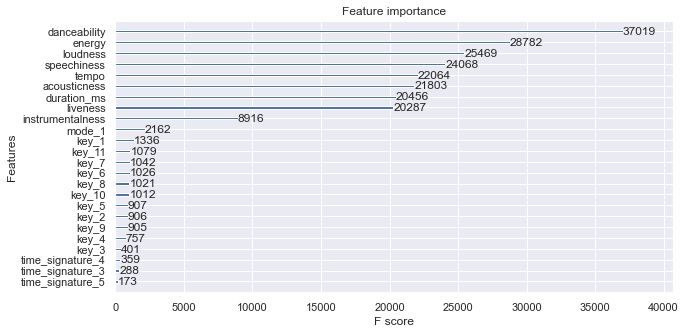

In [102]:
model.get_booster().feature_names = ['danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness','tempo', 'duration_ms', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'mode_1', 'time_signature_3', 'time_signature_4', 'time_signature_5']
plot_importance(model.get_booster())

* We observe that the most significant features remain the same as the above, but now we have a better mean absolute error and a smaller $R ^2$ value, as we drop some rows(and so the explained variance of our model decreased).

#### NN

In [103]:
df_train_nn = f_df[['danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness','tempo', 'duration_ms', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'mode_1','time_signature_3', 'time_signature_4', 'time_signature_5','valence']]

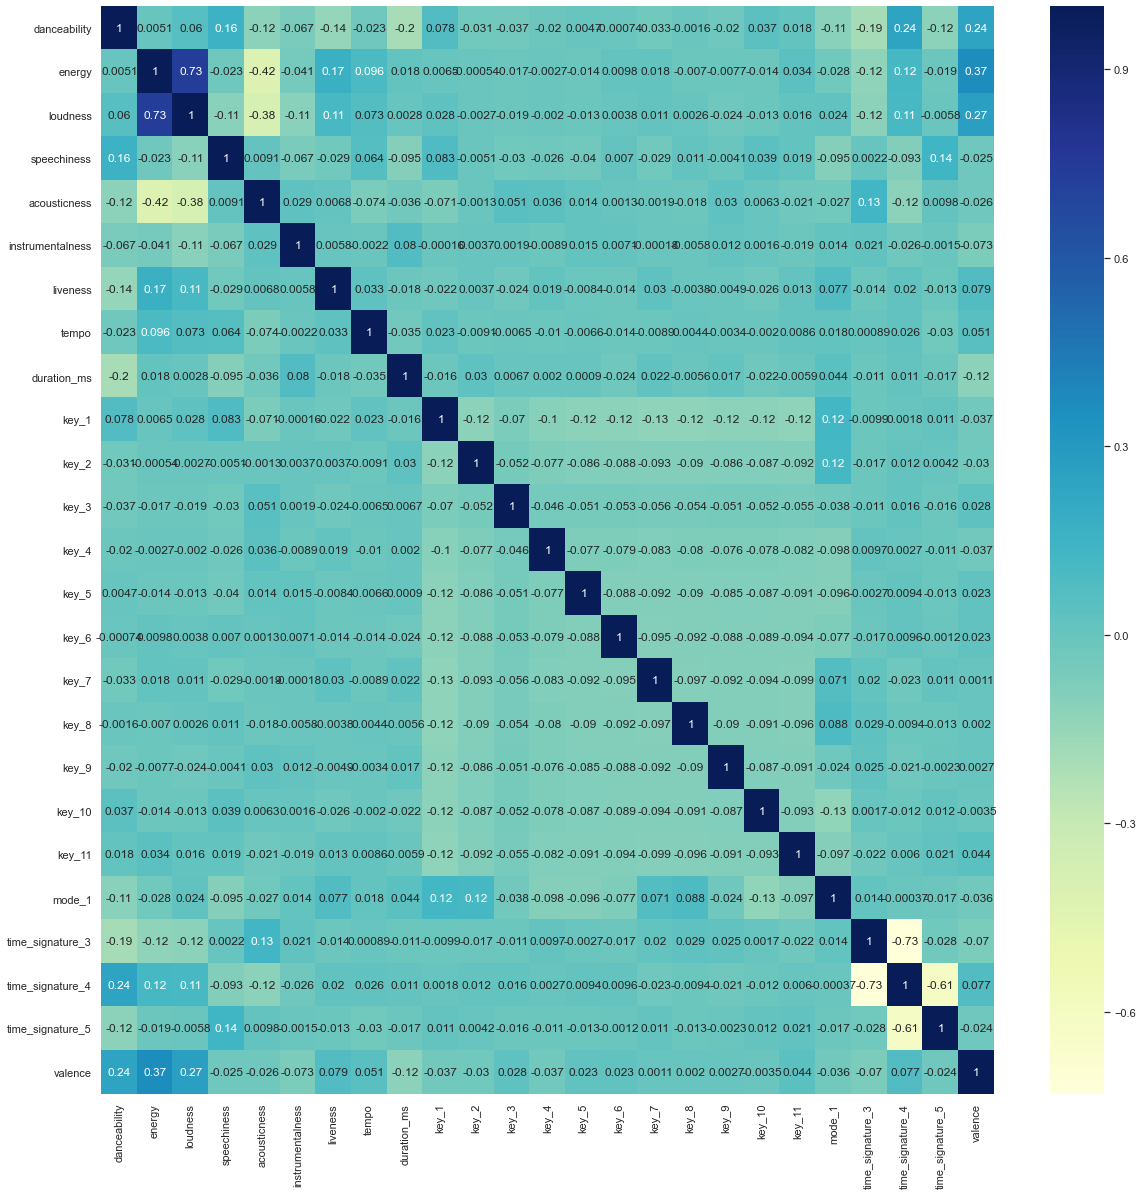

In [104]:
sns.set(rc = {'figure.figsize':(20,20)})  
# plotting correlation heatmap
dataplot = sns.heatmap(df_train_nn.corr(), cmap="YlGnBu", annot=True)
# displaying heatmap
plt.show()

In [105]:
train_data = df_train_nn.sample(frac=0.8,random_state=0)

In [106]:
train_data

danceability  energy  loudness  speechiness  acousticness  \
223396         0.844   0.783    -6.214       0.0348      0.478000   
211559         0.452   0.685    -7.143       0.3360      0.121000   
24910          0.461   0.834    -4.868       0.0989      0.023200   
153508         0.745   0.642    -6.257       0.2870      0.020400   
236281         0.859   0.308   -13.086       0.2670      0.222000   
...              ...     ...       ...          ...           ...   
194467         0.726   0.723    -3.827       0.1050      0.212000   
227998         0.790   0.707    -7.089       0.1130      0.239000   
271733         0.486   0.949    -2.397       0.0565      0.000272   
233158         0.742   0.748    -6.881       0.2740      0.695000   
250596         0.652   0.727    -5.976       0.0582      0.504000   

        instrumentalness  liveness    tempo  duration_ms  key_1  ...  key_7  \
223396          0.000000    0.2420  125.979       209032      0  ...      0   
211559          0.000000    0.1270   85.718       270027      0  ...      0   
24910           0.000011    0.1400  135.007       261154      0  ...      0   
153508          0.000000    0.0658  179.974       131280      0  ...      1   
236281          0.000000    0.0918  120.081       212250      0  ...      0   
...                  ...       ...      ...          ...    ...  ...    ...   
194467          0.000000    0.1130  108.028       200469      0  ...      1   
227998          0.000000    0.0859  102.024       174813      0  ...      0   
271733          0.000000    0.1880   97.268       214088      0  ...      1   
233158          0.000000    0.1930  115.925       206320      0  ...      0   
250596          0.000000    0.4690  144.738       192026      0  ...      0   

        key_8  key_9  key_10  key_11  mode_1  time_signature_3  \
223396      0      0       0       0       0                 0   
211559      0      0       1       0       0                 0   
24910       0      0       0       0       1                 0   
153508      0      0       0       0       0                 0   
236281      0      0       0       0       0                 0   
...       ...    ...     ...     ...     ...               ...   
194467      0      0       0       0       1                 0   
227998      1      0       0       0       0                 0   
271733      0      0       0       0       1                 0   
233158      0      0       1       0       0                 0   
250596      0      1       0       0       1                 0   

        time_signature_4  time_signature_5  valence  
223396                 1                 0    0.944  
211559                 1                 0    0.673  
24910                  1                 0    0.471  
153508                 1                 0    0.226  
236281                 1                 0    0.406  
...                  ...               ...      ...  
194467                 1                 0    0.211  
227998                 1                 0    0.651  
271733                 1                 0    0.358  
233158                 1                 0    0.198  
250596                 1                 0    0.165  

[11104 rows x 25 columns]

In [107]:
test_data = df_train_nn.drop(train_data.index)

In [108]:
train_data.describe().transpose()

count           mean           std           min  \
danceability      11104.0       0.687045      0.142018      0.118000   
energy            11104.0       0.664378      0.161489      0.027900   
loudness          11104.0      -6.320296      2.404684    -34.475000   
speechiness       11104.0       0.153511      0.130935      0.023100   
acousticness      11104.0       0.250949      0.233992      0.000003   
instrumentalness  11104.0       0.008099      0.061166      0.000000   
liveness          11104.0       0.180931      0.150841      0.019700   
tempo             11104.0     122.135915     28.064636     46.489000   
duration_ms       11104.0  207660.819074  50960.855230  30400.000000   
key_1             11104.0       0.135807      0.342599      0.000000   
key_2             11104.0       0.080872      0.272650      0.000000   
key_3             11104.0       0.030079      0.170813      0.000000   
key_4             11104.0       0.063581      0.244015      0.000000   
key_5             11104.0       0.079521      0.270562      0.000000   
key_6             11104.0       0.082853      0.275672      0.000000   
key_7             11104.0       0.089067      0.284853      0.000000   
key_8             11104.0       0.086906      0.281709      0.000000   
key_9             11104.0       0.077990      0.268168      0.000000   
key_10            11104.0       0.081412      0.273479      0.000000   
key_11            11104.0       0.090238      0.286535      0.000000   
mode_1            11104.0       0.525396      0.499377      0.000000   
time_signature_3  11104.0       0.033231      0.179248      0.000000   
time_signature_4  11104.0       0.939932      0.237624      0.000000   
time_signature_5  11104.0       0.023145      0.150370      0.000000   
valence           11104.0       0.502332      0.214445      0.035400   

                           25%          50%            75%          max  
danceability           0.59700       0.7040       0.792000        0.978  
energy                 0.56400       0.6790       0.783000        0.999  
loudness              -7.49625      -6.0445      -4.768000        1.107  
speechiness            0.04990       0.0975       0.240000        0.966  
acousticness           0.05980       0.1780       0.383000        0.994  
instrumentalness       0.00000       0.0000       0.000015        0.960  
liveness               0.09610       0.1220       0.207250        0.989  
tempo                 99.93500     121.0745     140.040000      212.117  
duration_ms       177732.50000  201399.5000  228898.750000  1109080.000  
key_1                  0.00000       0.0000       0.000000        1.000  
key_2                  0.00000       0.0000       0.000000        1.000  
key_3                  0.00000       0.0000       0.000000        1.000  
key_4                  0.00000       0.0000       0.000000        1.000  
key_5                  0.00000       0.0000       0.000000        1.000  
key_6                  0.00000       0.0000       0.000000        1.000  
key_7                  0.00000       0.0000       0.000000        1.000  
key_8                  0.00000       0.0000       0.000000        1.000  
key_9                  0.00000       0.0000       0.000000        1.000  
key_10                 0.00000       0.0000       0.000000        1.000  
key_11                 0.00000       0.0000       0.000000        1.000  
mode_1                 0.00000       1.0000       1.000000        1.000  
time_signature_3       0.00000       0.0000       0.000000        1.000  
time_signature_4       1.00000       1.0000       1.000000        1.000  
time_signature_5       0.00000       0.0000       0.000000        1.000  
valence                0.34100       0.5010       0.665000        0.982

In [109]:
train_labels = train_data.pop('valence').values
test_labels = test_data.pop('valence').values

In [110]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_data))
with np.printoptions(precision=2):
    print(normalizer.mean)
    print(normalizer.variance)
    print(normalizer.count)

tf.Tensor(
[[ 6.87e-01  6.64e-01 -6.32e+00  1.54e-01  2.51e-01  8.10e-03  1.81e-01
   1.22e+02  2.08e+05  1.36e-01  8.09e-02  3.01e-02  6.36e-02  7.95e-02
   8.29e-02  8.91e-02  8.69e-02  7.80e-02  8.14e-02  9.02e-02  5.25e-01
   3.32e-02  9.40e-01  2.31e-02]], shape=(1, 24), dtype=float32)
tf.Tensor(
[[2.02e-02 2.61e-02 5.78e+00 1.71e-02 5.47e-02 3.74e-03 2.28e-02 7.88e+02
  2.60e+09 1.17e-01 7.43e-02 2.92e-02 5.95e-02 7.32e-02 7.60e-02 8.11e-02
  7.94e-02 7.19e-02 7.48e-02 8.21e-02 2.49e-01 3.21e-02 5.65e-02 2.26e-02]], shape=(1, 24), dtype=float32)
<tf.Variable 'count:0' shape=() dtype=int64, numpy=11104>


* We will build a sequential neural network.

* We will have two dense layers of 128 nodes and then a final output layer.

* The final output layer will have a single unit and no activation function. 

* We don't want an activation function because we don't want to constrain the output value that we will predict from the regression.

* Therefore the output will be purely linear.

In [111]:
def build_compile_model():
    model = tf.keras.Sequential([
        normalizer,
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
])
    
    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model

nn = build_compile_model()

In [112]:
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 24)               49        
 n)                                                              
                                                                 
 dense (Dense)               (None, 128)               3200      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
Total params: 19,761
Trainable params: 19,712
Non-trainable params: 49
_________________________________________________________________


In [113]:
num_epochs = 100

history = nn.fit(
    train_data, 
    train_labels,
    epochs=num_epochs, 
    validation_split=0.2,
    verbose=1)

Epoch 1/100
278/278 [==============================] - 2s 2ms/step - loss: 0.1966 - val_loss: 0.1617
Epoch 2/100
278/278 [==============================] - 0s 2ms/step - loss: 0.1577 - val_loss: 0.1539
Epoch 3/100
278/278 [==============================] - 0s 2ms/step - loss: 0.1532 - val_loss: 0.1531
Epoch 4/100
278/278 [==============================] - 0s 2ms/step - loss: 0.1506 - val_loss: 0.1510
Epoch 5/100
278/278 [==============================] - 0s 2ms/step - loss: 0.1487 - val_loss: 0.1522
Epoch 6/100
278/278 [==============================] - 0s 2ms/step - loss: 0.1478 - val_loss: 0.1496
Epoch 7/100
278/278 [==============================] - 0s 2ms/step - loss: 0.1469 - val_loss: 0.1498
Epoch 8/100
278/278 [==============================] - 0s 2ms/step - loss: 0.1463 - val_loss: 0.1495
Epoch 9/100
278/278 [==============================] - 0s 2ms/step - loss: 0.1457 - val_loss: 0.1476
Epoch 10/100
278/278 [==============================] - 0s 2ms/step - loss: 0.1453 - val_lo

In [114]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss  val_loss  epoch
95  0.125889  0.150901     95
96  0.125816  0.149912     96
97  0.125629  0.150392     97
98  0.125214  0.150089     98
99  0.125358  0.150997     99

In [115]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

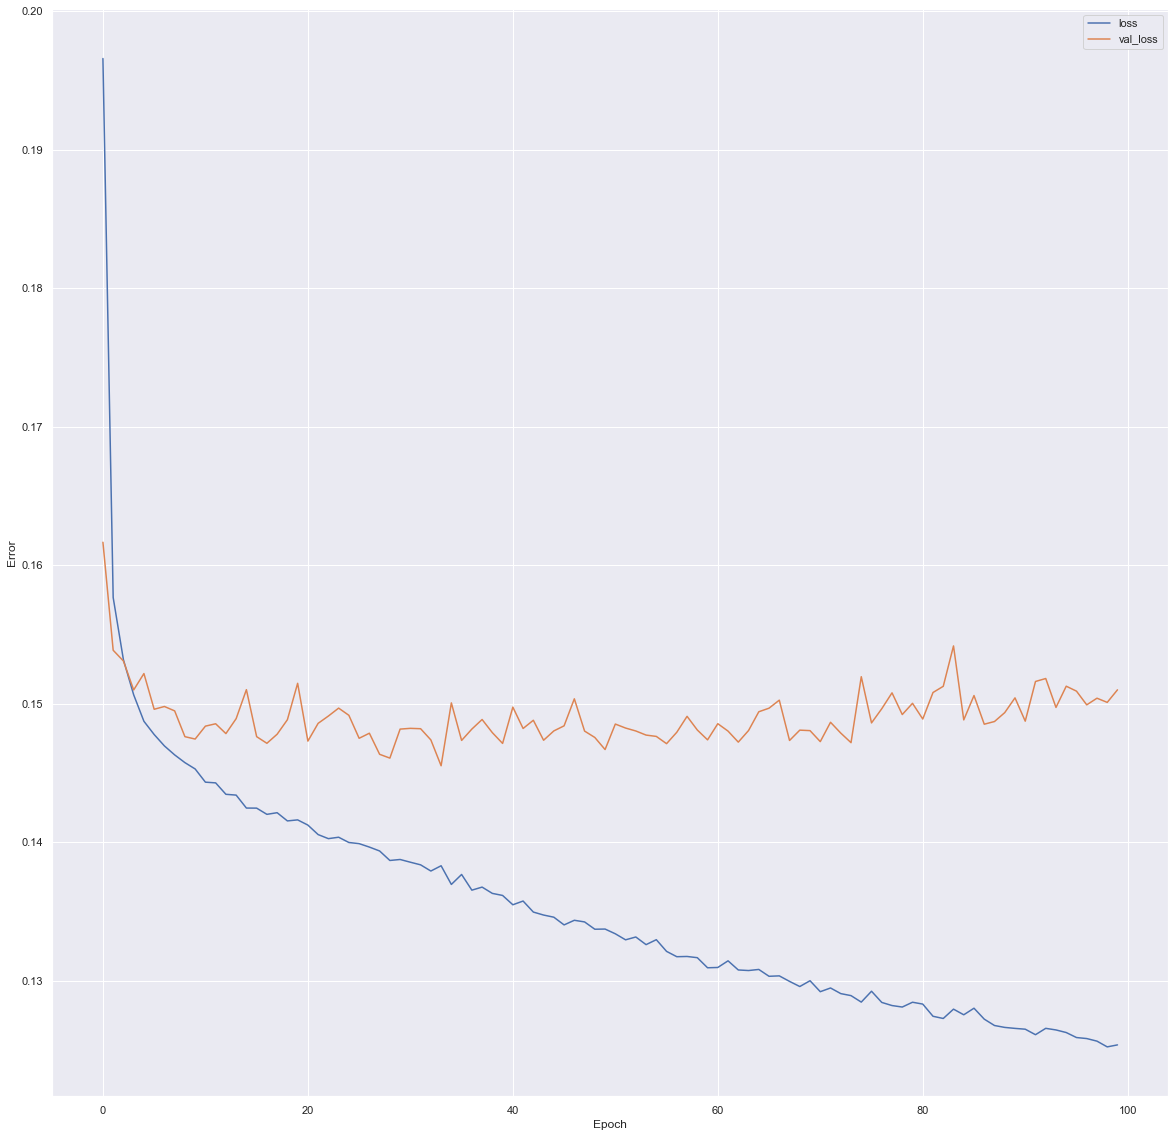

In [116]:
plot_loss(history)

In [117]:
nn.evaluate(test_data, test_labels, verbose=0)

0.15053662657737732

* We observe that the model does not fit well, as the two curves diverge, so we run this model again but now using Early stopping.

In [118]:
nn = build_compile_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = nn.fit(train_data, train_labels, epochs=num_epochs,
                    validation_split = 0.2, verbose=1, 
                    callbacks=[early_stop])
nn.evaluate(test_data, test_labels, verbose=0)

Epoch 1/100
278/278 [==============================] - 1s 2ms/step - loss: 0.2013 - val_loss: 0.1625
Epoch 2/100
278/278 [==============================] - 0s 2ms/step - loss: 0.1577 - val_loss: 0.1559
Epoch 3/100
278/278 [==============================] - 0s 2ms/step - loss: 0.1522 - val_loss: 0.1542
Epoch 4/100
278/278 [==============================] - 0s 2ms/step - loss: 0.1502 - val_loss: 0.1508
Epoch 5/100
278/278 [==============================] - 0s 2ms/step - loss: 0.1487 - val_loss: 0.1488
Epoch 6/100
278/278 [==============================] - 0s 2ms/step - loss: 0.1477 - val_loss: 0.1497
Epoch 7/100
278/278 [==============================] - 0s 2ms/step - loss: 0.1467 - val_loss: 0.1502
Epoch 8/100
278/278 [==============================] - 0s 2ms/step - loss: 0.1462 - val_loss: 0.1490
Epoch 9/100
278/278 [==============================] - 0s 2ms/step - loss: 0.1456 - val_loss: 0.1493
Epoch 10/100
278/278 [==============================] - 0s 2ms/step - loss: 0.1447 - val_lo

0.1465345323085785

* And we observe that less epochs were needed to achieve a better score.

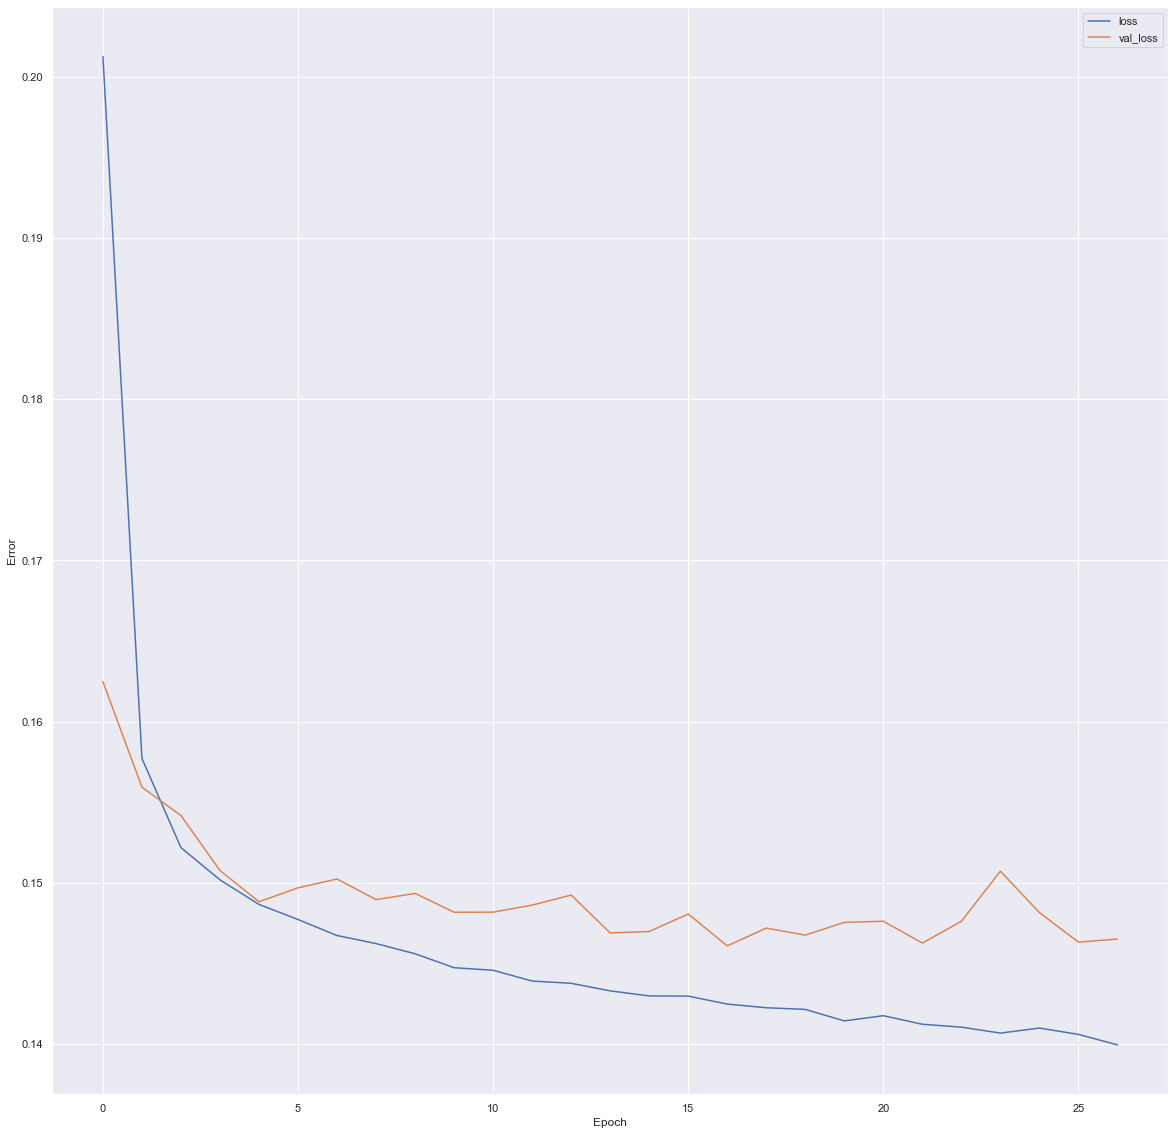

In [119]:
plot_loss(history)

* Also we can observe that we have an improvement, as the two curves are now closer, but still they havent converge(it is an evidence of overfitting), so we could try another, more complex model. So, we create a model with 4 hidden layers with 512 neurons each, using regularization and 50% dropout.

In [120]:
def build_compile_model_complex():
    model = tf.keras.Sequential([
        normalizer,
    layers.Dense(512,kernel_regularizer=regularizers.l2(0.0001), activation='relu' ),
    layers.Dropout(0.5),
    layers.Dense(512,kernel_regularizer=regularizers.l2(0.0001), activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512,kernel_regularizer=regularizers.l2(0.0001), activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512,kernel_regularizer=regularizers.l2(0.0001), activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])
    
    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model

nn_c = build_compile_model_complex()

In [121]:
nn_c.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 24)               49        
 n)                                                              
                                                                 
 dense_4 (Dense)             (None, 512)               12800     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                      

In [122]:
num_epochs = 100

history = nn_c.fit(
    train_data, 
    train_labels,
    epochs=num_epochs, 
    validation_split=0.2,
    verbose=1)

Epoch 1/100
278/278 [==============================] - 5s 14ms/step - loss: 0.3623 - val_loss: 0.3495
Epoch 2/100
278/278 [==============================] - 4s 13ms/step - loss: 0.3101 - val_loss: 0.2921
Epoch 3/100
278/278 [==============================] - 4s 14ms/step - loss: 0.2864 - val_loss: 0.2723
Epoch 4/100
278/278 [==============================] - 4s 13ms/step - loss: 0.2653 - val_loss: 0.2576
Epoch 5/100
278/278 [==============================] - 4s 13ms/step - loss: 0.2479 - val_loss: 0.2353
Epoch 6/100
278/278 [==============================] - 4s 13ms/step - loss: 0.2318 - val_loss: 0.2189
Epoch 7/100
278/278 [==============================] - 3s 13ms/step - loss: 0.2179 - val_loss: 0.2063
Epoch 8/100
278/278 [==============================] - 4s 13ms/step - loss: 0.2069 - val_loss: 0.1952
Epoch 9/100
278/278 [==============================] - 4s 13ms/step - loss: 0.1948 - val_loss: 0.1884
Epoch 10/100
278/278 [==============================] - 4s 13ms/step - loss: 0.187

In [123]:
nn_c.evaluate(test_data, test_labels, verbose=0)

0.1551254242658615

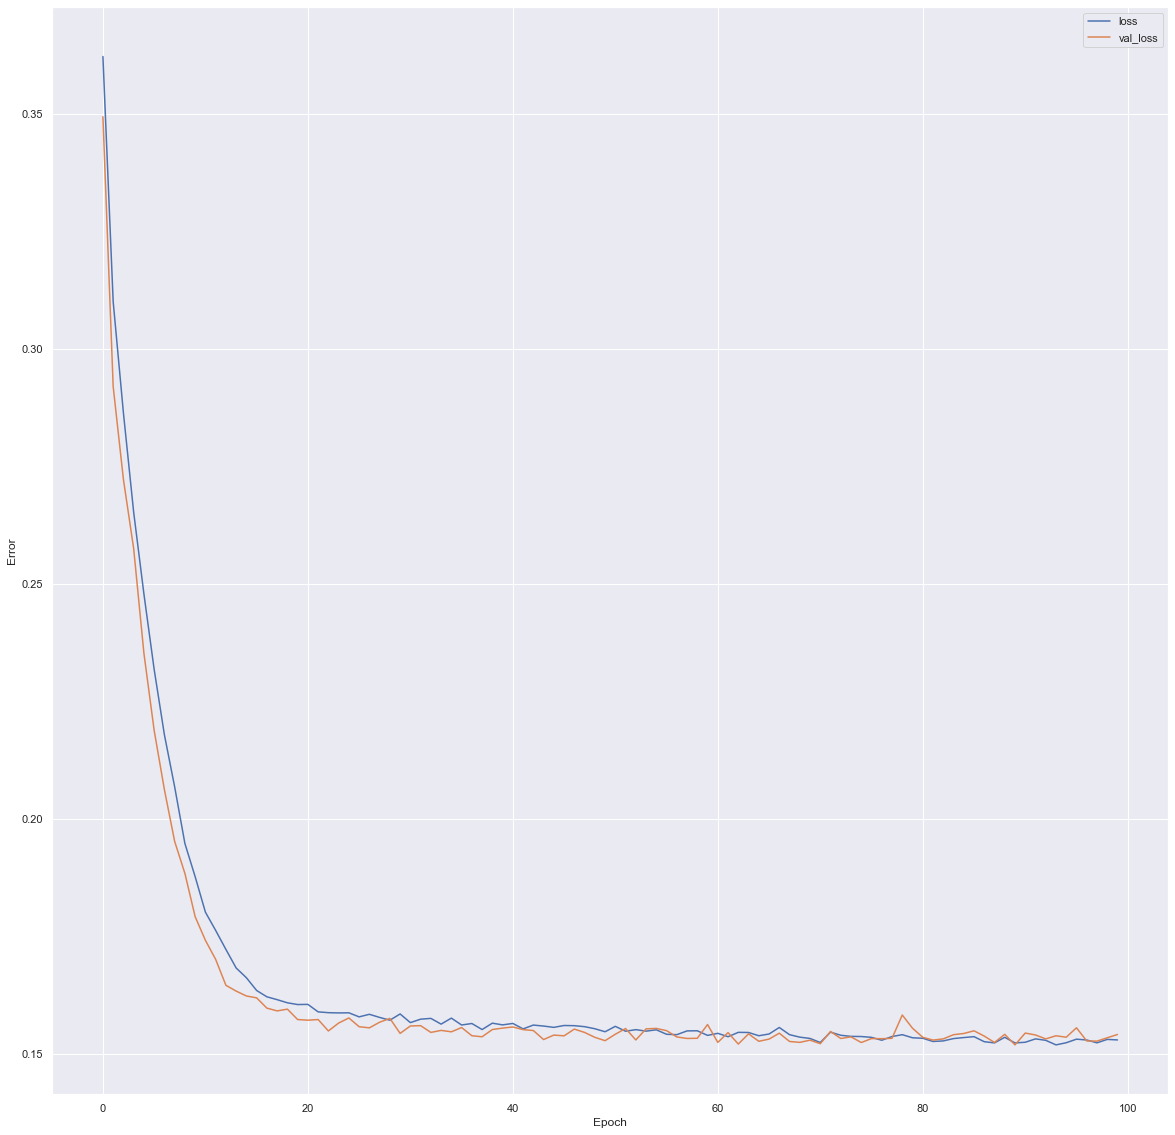

In [124]:
plot_loss(history)

* Now with a more complex model we have a bigger score, but the two curves seem to converge, in other words we have avoid overfitting but our model does not generalize well.

------

* Again by using the quantile based flooring and capping

In [125]:
df_train_nn = f_df[['danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness','tempo', 'duration_ms', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'mode_1', 'time_signature_3', 'time_signature_4', 'time_signature_5','valence']]

In [126]:
q_low = df_train_nn["valence"].quantile(0.015)
q_hi  = df_train_nn["valence"].quantile(0.985)

df_filtered = df_train_nn[(df_train_nn["valence"] < q_hi) & (df_train_nn["valence"] > q_low)]

In [127]:
df_filtered

danceability  energy  loudness  speechiness  acousticness  \
0              0.681   0.594    -7.028       0.2820       0.16500   
428            0.720   0.763    -4.068       0.0523       0.40600   
809            0.748   0.524    -5.599       0.0338       0.41400   
2041           0.670   0.838    -4.031       0.0362       0.06040   
2360           0.773   0.819    -5.946       0.1180       0.42600   
...              ...     ...       ...          ...           ...   
273595         0.810   0.690    -7.841       0.2700       0.03730   
273596         0.942   0.531    -7.510       0.2150       0.00236   
273597         0.762   0.679    -7.595       0.1920       0.04260   
273598         0.774   0.836    -2.323       0.1520       0.28800   
273599         0.894   0.511    -4.768       0.4210       0.02510   

        instrumentalness  liveness    tempo  duration_ms  key_1  ...  key_7  \
0               0.000003    0.1340  186.054       230453      0  ...      1   
428             0.000000    0.1800  101.965       251088      0  ...      0   
809             0.000000    0.1110   95.010       244960      0  ...      0   
2041            0.000611    0.1590  104.998       222041      0  ...      0   
2360            0.000000    0.0679   92.990       269187      0  ...      0   
...                  ...       ...      ...          ...    ...  ...    ...   
273595          0.000000    0.1060  139.970       140369      0  ...      0   
273596          0.000106    0.0812   99.027       157520      1  ...      0   
273597          0.000000    0.1860  150.051       125320      0  ...      0   
273598          0.000024    0.0824  112.014       201271      0  ...      0   
273599          0.000000    0.1400  120.077       176632      0  ...      0   

        key_8  key_9  key_10  key_11  mode_1  time_signature_3  \
0           0      0       0       0       1                 0   
428         0      1       0       0       0                 0   
809         1      0       0       0       1                 0   
2041        0      0       0       0       1                 0   
2360        0      0       0       0       0                 0   
...       ...    ...     ...     ...     ...               ...   
273595      0      0       1       0       0                 0   
273596      0      0       0       0       1                 0   
273597      0      0       0       0       0                 0   
273598      0      1       0       0       0                 0   
273599      0      0       0       0       1                 0   

        time_signature_4  time_signature_5  valence  
0                      1                 0    0.535  
428                    1                 0    0.742  
809                    1                 0    0.661  
2041                   1                 0    0.717  
2360                   1                 0    0.585  
...                  ...               ...      ...  
273595                 1                 0    0.618  
273596                 1                 0    0.740  
273597                 1                 0    0.328  
273598                 1                 0    0.494  
273599                 1                 0    0.567  

[13459 rows x 25 columns]

In [128]:
train_data = df_filtered.sample(frac=0.8,random_state=0)

In [129]:
train_data

danceability  energy  loudness  speechiness  acousticness  \
197029         0.474   0.257   -10.772       0.0320       0.99200   
218922         0.621   0.698    -6.533       0.2460       0.24200   
247440         0.465   0.811    -4.914       0.3050       0.07410   
267070         0.662   0.805    -4.080       0.0296       0.00448   
206385         0.830   0.765    -4.205       0.1010       0.02320   
...              ...     ...       ...          ...           ...   
177751         0.884   0.570    -2.451       0.0503       0.22500   
213951         0.713   0.673    -8.296       0.4480       0.60600   
245246         0.966   0.371   -12.587       0.2730       0.19800   
209040         0.654   0.719    -6.684       0.5240       0.23900   
218055         0.736   0.555    -4.689       0.0757       0.03450   

        instrumentalness  liveness    tempo  duration_ms  key_1  ...  key_7  \
197029          0.000510    0.3150  101.895       137720      0  ...      0   
218922          0.000000    0.0902  198.882       221928      0  ...      0   
247440          0.000531    0.1400  172.283       227243      0  ...      1   
267070          0.000000    0.1140  129.996       286573      0  ...      0   
206385          0.015900    0.0754  102.028       188040      0  ...      1   
...                  ...       ...      ...          ...    ...  ...    ...   
177751          0.000000    0.2000  129.967       142154      0  ...      1   
213951          0.000004    0.1660   80.117       213339      0  ...      0   
245246          0.000000    0.1400  117.996       167235      1  ...      0   
209040          0.000000    0.2410  118.339       183662      0  ...      0   
218055          0.000157    0.0798   91.997       222320      0  ...      0   

        key_8  key_9  key_10  key_11  mode_1  time_signature_3  \
197029      0      0       0       0       0                 0   
218922      1      0       0       0       1                 0   
247440      0      0       0       0       1                 0   
267070      0      0       0       0       1                 0   
206385      0      0       0       0       0                 0   
...       ...    ...     ...     ...     ...               ...   
177751      0      0       0       0       1                 0   
213951      0      0       0       0       0                 0   
245246      0      0       0       0       0                 0   
209040      0      0       0       0       0                 0   
218055      0      0       0       0       1                 0   

        time_signature_4  time_signature_5  valence  
197029                 0                 1    0.684  
218922                 1                 0    0.437  
247440                 0                 1    0.513  
267070                 1                 0    0.584  
206385                 1                 0    0.367  
...                  ...               ...      ...  
177751                 1                 0    0.817  
213951                 1                 0    0.663  
245246                 1                 0    0.555  
209040                 0                 1    0.643  
218055                 1                 0    0.323  

[10767 rows x 25 columns]

In [130]:
test_data = df_filtered.drop(train_data.index)

In [131]:
train_data.describe().transpose()

count           mean           std           min  \
danceability      10767.0       0.687232      0.140982      0.125000   
energy            10767.0       0.666771      0.160016      0.027900   
loudness          10767.0      -6.269411      2.358500    -34.475000   
speechiness       10767.0       0.154515      0.131119      0.023100   
acousticness      10767.0       0.248144      0.231846      0.000003   
instrumentalness  10767.0       0.007533      0.058750      0.000000   
liveness          10767.0       0.181996      0.152782      0.019700   
tempo             10767.0     122.094250     27.982039     46.489000   
duration_ms       10767.0  206907.122411  50125.520971  30400.000000   
key_1             10767.0       0.138200      0.345126      0.000000   
key_2             10767.0       0.079688      0.270822      0.000000   
key_3             10767.0       0.029535      0.169308      0.000000   
key_4             10767.0       0.062506      0.242083      0.000000   
key_5             10767.0       0.079781      0.270966      0.000000   
key_6             10767.0       0.082010      0.274392      0.000000   
key_7             10767.0       0.091390      0.288177      0.000000   
key_8             10767.0       0.085539      0.279695      0.000000   
key_9             10767.0       0.077459      0.267331      0.000000   
key_10            10767.0       0.080988      0.272830      0.000000   
key_11            10767.0       0.090276      0.286590      0.000000   
mode_1            10767.0       0.528281      0.499223      0.000000   
time_signature_3  10767.0       0.033621      0.180261      0.000000   
time_signature_4  10767.0       0.938144      0.240904      0.000000   
time_signature_5  10767.0       0.024241      0.153803      0.000000   
valence           10767.0       0.504346      0.203108      0.091000   

                          25%          50%            75%          max  
danceability           0.5970       0.7020       0.792000        0.980  
energy                 0.5680       0.6820       0.784000        0.997  
loudness              -7.4300      -6.0070      -4.740000        1.107  
speechiness            0.0507       0.0994       0.241000        0.966  
acousticness           0.0597       0.1770       0.376500        0.994  
instrumentalness       0.0000       0.0000       0.000013        0.960  
liveness               0.0961       0.1230       0.210000        0.989  
tempo                 99.9260     121.0130     140.041000      212.117  
duration_ms       177358.5000  200800.0000  228137.000000  1109080.000  
key_1                  0.0000       0.0000       0.000000        1.000  
key_2                  0.0000       0.0000       0.000000        1.000  
key_3                  0.0000       0.0000       0.000000        1.000  
key_4                  0.0000       0.0000       0.000000        1.000  
key_5                  0.0000       0.0000       0.000000        1.000  
key_6                  0.0000       0.0000       0.000000        1.000  
key_7                  0.0000       0.0000       0.000000        1.000  
key_8                  0.0000       0.0000       0.000000        1.000  
key_9                  0.0000       0.0000       0.000000        1.000  
key_10                 0.0000       0.0000       0.000000        1.000  
key_11                 0.0000       0.0000       0.000000        1.000  
mode_1                 0.0000       1.0000       1.000000        1.000  
time_signature_3       0.0000       0.0000       0.000000        1.000  
time_signature_4       1.0000       1.0000       1.000000        1.000  
time_signature_5       0.0000       0.0000       0.000000        1.000  
valence                0.3480       0.5030       0.663000        0.928

In [132]:
train_labels = train_data.pop('valence').values
test_labels = test_data.pop('valence').values

In [137]:
num_epochs = 100
nn = build_compile_model()
history = nn.fit(
    train_data, 
    train_labels,
    epochs=num_epochs, 
    validation_split=0.2,
    verbose=1,callbacks=[early_stop])

Epoch 1/100
270/270 [==============================] - 1s 2ms/step - loss: 0.1935 - val_loss: 0.1595
Epoch 2/100
270/270 [==============================] - 0s 2ms/step - loss: 0.1524 - val_loss: 0.1517
Epoch 3/100
270/270 [==============================] - 0s 2ms/step - loss: 0.1475 - val_loss: 0.1488
Epoch 4/100
270/270 [==============================] - 0s 2ms/step - loss: 0.1449 - val_loss: 0.1474
Epoch 5/100
270/270 [==============================] - 1s 2ms/step - loss: 0.1434 - val_loss: 0.1469
Epoch 6/100
270/270 [==============================] - 0s 2ms/step - loss: 0.1421 - val_loss: 0.1466
Epoch 7/100
270/270 [==============================] - 0s 2ms/step - loss: 0.1411 - val_loss: 0.1463
Epoch 8/100
270/270 [==============================] - 1s 2ms/step - loss: 0.1411 - val_loss: 0.1461
Epoch 9/100
270/270 [==============================] - 0s 2ms/step - loss: 0.1405 - val_loss: 0.1466
Epoch 10/100
270/270 [==============================] - 0s 2ms/step - loss: 0.1396 - val_lo

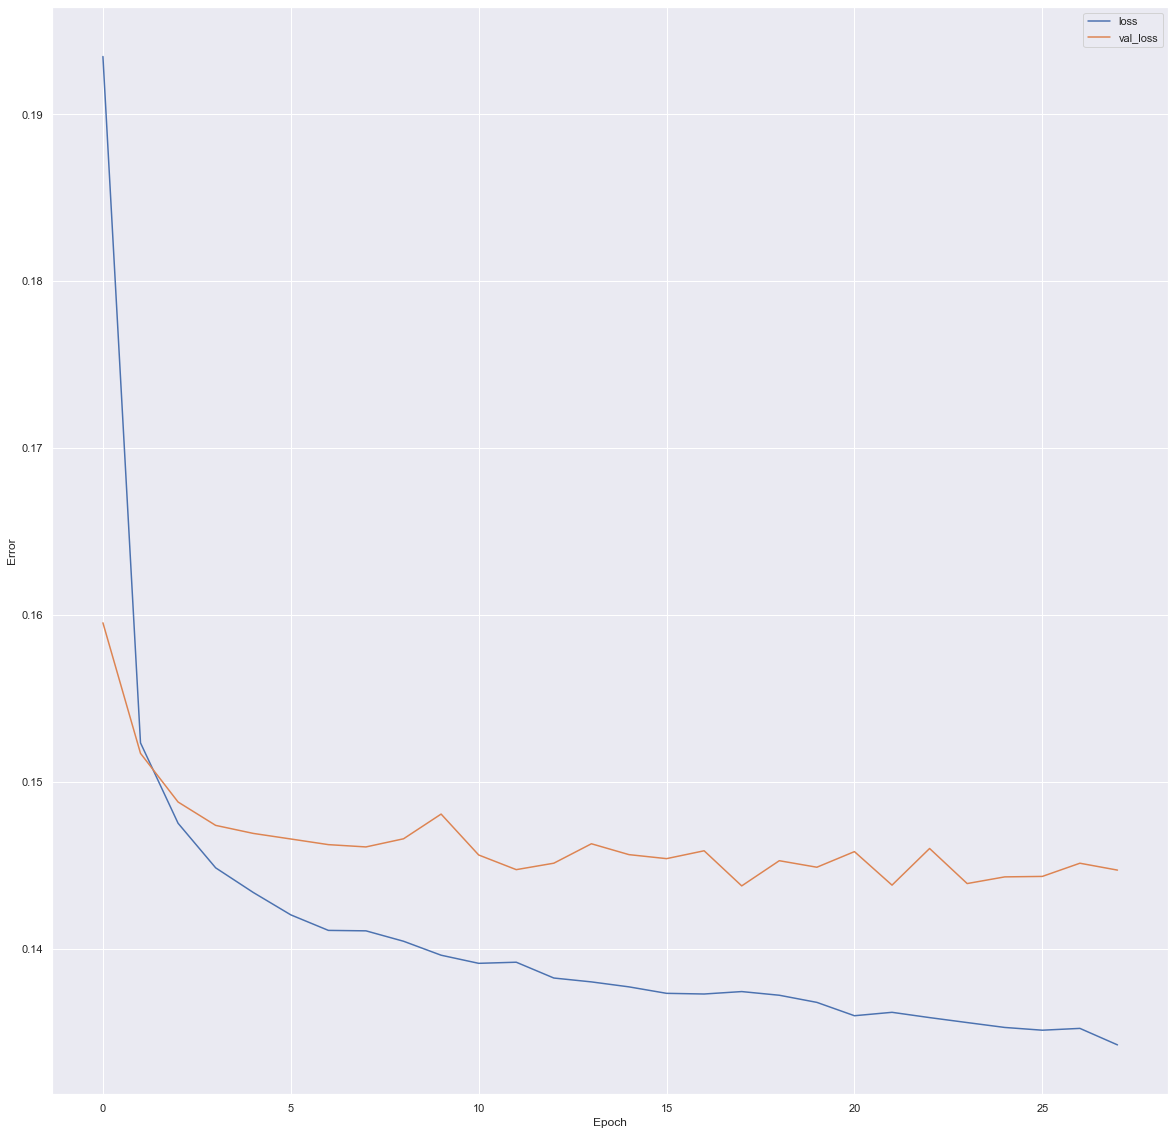

In [138]:
plot_loss(history)

In [140]:
nn.evaluate(test_data, test_labels, verbose=0)

0.14306199550628662

* To sum up, we cannot predict precisely the valence, in other words our models cannot mimic the Spotify's equivalent(our models have on average an absolute difference of ~13% from the actual valence). As the Spotify's model may use more features (like the track's genre,etc) and surely more data.

#### Evaluation on Given Test Dataset

In [141]:
charts

position                 song_id  \
0            1.0  5aAx2yezTd8zXrkmtKl66Z   
428          2.0  5knuzwU65gJK7IF5yJsuaW   
809          3.0  7BKLCZ1jbUBVqRi2FVlTVw   
1587         4.0  3NdDpSvN911VPGivFlV5d0   
2041         5.0  78rIJddV4X0HkNAInEcYde   
...          ...                     ...   
274626       NaN  4lUmnwRybYH7mMzf16xB0y   
274627       NaN  1fzf9Aad4y1RWrmwosAK5y   
274628       NaN  3E3pb3qH11iny6TFDJvsg5   
274629       NaN  3yTkoTuiKRGL2VAlQd7xsC   
274630       NaN  4JE6agBLHGA5TaF6FlqfBD   

                                                song_name            artist  \
0                                                 Starboy        The Weeknd   
428               Rockabye (feat. Sean Paul & Anne-Marie)      Clean Bandit   
809                                                Closer  The Chainsmokers   
1587    I Don’t Wanna Live Forever (Fifty Shades Darke...              ZAYN   
2041              Call On Me - Ryan Riback Extended Remix           Starley   
...                                                   ...               ...   
274626                                                NaN               NaN   
274627                                                NaN               NaN   
274628                                                NaN               NaN   
274629                                                NaN               NaN   
274630                                                NaN               NaN   

         streams  last_week_position  weeks_on_chart  peak_position  \
0       947261.0                 NaN             1.0            1.0   
428     893107.0                 NaN             1.0            2.0   
809     871617.0                 NaN             1.0            3.0   
1587    791592.0                 NaN             1.0            4.0   
2041    743490.0                 NaN             1.0            5.0   
...          ...                 ...             ...            ...   
274626       NaN                 NaN             NaN            NaN   
274627       NaN                 NaN             NaN            NaN   
274628       NaN                 NaN             NaN            NaN   
274629       NaN                 NaN             NaN            NaN   
274630       NaN                 NaN             NaN            NaN   

       position_status week_start  ... liveness valence    tempo  \
0                  new 2016-12-30  ...   0.1340  0.5350  186.054   
428                new 2016-12-30  ...   0.1800  0.7420  101.965   
809                new 2016-12-30  ...   0.1110  0.6610   95.010   
1587               new 2016-12-30  ...   0.3250  0.0862  117.973   
2041               new 2016-12-30  ...   0.1590  0.7170  104.998   
...                ...        ...  ...      ...     ...      ...   
274626             NaN        NaT  ...   0.1400  0.1880  133.997   
274627             NaN        NaT  ...   0.0465  0.7680   93.003   
274628             NaN        NaT  ...   0.1940  0.3160   83.000   
274629             NaN        NaT  ...   0.0663  0.4840  104.973   
274630             NaN        NaT  ...   0.2200  0.1800  123.829   

                  type                      id  \
0       audio_features  5aAx2yezTd8zXrkmtKl66Z   
428     audio_features  5knuzwU65gJK7IF5yJsuaW   
809     audio_features  7BKLCZ1jbUBVqRi2FVlTVw   
1587    audio_features  3NdDpSvN911VPGivFlV5d0   
2041    audio_features  78rIJddV4X0HkNAInEcYde   
...                ...                     ...   
274626  audio_features  4lUmnwRybYH7mMzf16xB0y   
274627  audio_features  1fzf9Aad4y1RWrmwosAK5y   
274628  audio_features  3E3pb3qH11iny6TFDJvsg5   
274629  audio_features  3yTkoTuiKRGL2VAlQd7xsC   
274630  audio_features  4JE6agBLHGA5TaF6FlqfBD   

                                         uri  \
0       spotify:track:5aAx2yezTd8zXrkmtKl66Z   
428     spotify:track:5knuzwU65gJK7IF5yJsuaW   
809     spotify:track:7BKLCZ1jbUBVqRi2FVlTVw   
1587    spotify:track:3NdDpSvN911VPGivFlV5d0   
2041    spotify:tra

In [142]:
charts.drop(['analysis_url', 'id', 'track_href','uri','id','type','peak_position','last_week_position','weeks_on_chart','position_status','week_start','week_end','streams','region','position'], axis=1, inplace=True)

In [143]:
f_df =  pd.get_dummies(data=charts, columns=['key', 'mode', 'time_signature'],drop_first=True)

In [144]:
f_df

song_id  \
0       5aAx2yezTd8zXrkmtKl66Z   
428     5knuzwU65gJK7IF5yJsuaW   
809     7BKLCZ1jbUBVqRi2FVlTVw   
1587    3NdDpSvN911VPGivFlV5d0   
2041    78rIJddV4X0HkNAInEcYde   
...                        ...   
274626  4lUmnwRybYH7mMzf16xB0y   
274627  1fzf9Aad4y1RWrmwosAK5y   
274628  3E3pb3qH11iny6TFDJvsg5   
274629  3yTkoTuiKRGL2VAlQd7xsC   
274630  4JE6agBLHGA5TaF6FlqfBD   

                                                song_name            artist  \
0                                                 Starboy        The Weeknd   
428               Rockabye (feat. Sean Paul & Anne-Marie)      Clean Bandit   
809                                                Closer  The Chainsmokers   
1587    I Don’t Wanna Live Forever (Fifty Shades Darke...              ZAYN   
2041              Call On Me - Ryan Riback Extended Remix           Starley   
...                                                   ...               ...   
274626                                                NaN               NaN   
274627                                                NaN               NaN   
274628                                                NaN               NaN   
274629                                                NaN               NaN   
274630                                                NaN               NaN   

        danceability  energy  loudness  speechiness  acousticness  \
0              0.681   0.594    -7.028       0.2820        0.1650   
428            0.720   0.763    -4.068       0.0523        0.4060   
809            0.748   0.524    -5.599       0.0338        0.4140   
1587           0.735   0.451    -8.374       0.0585        0.0631   
2041           0.670   0.838    -4.031       0.0362        0.0604   
...              ...     ...       ...          ...           ...   
274626         0.596   0.650    -5.167       0.3370        0.1380   
274627         0.588   0.850    -6.431       0.0318        0.1680   
274628         0.754   0.660    -6.811       0.2670        0.1790   
274629         0.584   0.836    -4.925       0.0790        0.0558   
274630         0.331   0.450    -5.362       0.0340        0.3650   

        instrumentalness  liveness  ...  key_6  key_7  key_8  key_9  key_10  \
0               0.000003    0.1340  ...      0      1      0      0       0   
428             0.000000    0.1800  ...      0      0      0      1       0   
809             0.000000    0.1110  ...      0      0      1      0       0   
1587            0.000013    0.3250  ...      0      0      0      0       0   
2041            0.000611    0.1590  ...      0      0      0      0       0   
...                  ...       ...  ...    ...    ...    ...    ...     ...   
274626          0.000000    0.1400  ...      0      0      0      1       0   
274627          0.002020    0.0465  ...      0      0      0      0       0   
274628          0.000000    0.1940  ...      0      0      0      0       0   
274629          0.000000    0.0663  ...      0      0      0      0       0   
274630          0.004640    0.2200  ...      0      0      0      0       1   

        key_11  mode_1  time_signature_3  time_signature_4  time_signature_5  
0            0       1                 0                 1                 0  
428          0       0                 0                 1                 0  
809          0       1                 0                 1                 0  
1587         0       1                 0                 1                 0  
2041         0       1                 0                 1                 0  
...        ...     ...               ...               ...               ...  
274626       0       1                 0                 1                 0  
274627       0       1                 0                 1                 0  
274628       0       1                 0                 1                 0  
274629       0       1                 0                 1                 0  
274630       0    

In [145]:
f_df = f_df.sample(n=len(f_df), random_state=42)

* Removing our given test data set.

In [146]:
f_df_train = f_df[~f_df['song_id'].isin(content_list)] 
f_df_test = f_df[f_df['song_id'].isin(content_list)] 

In [147]:
print(len(f_df_train),len(f_df_test))

13749 1162


* Now we will drop the time signature columns as they are the less significant and highly correlated.

In [148]:
df_train_t = f_df_train[['danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness','tempo', 'duration_ms', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'mode_1']]
df_test_t = f_df_test[['danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness','tempo', 'duration_ms', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'mode_1']]

* Splitting on train and test set.In our train set will be all the data points that are not in our given test dataset.

In [149]:
x_train = np.array(df_train_t)
y_train1 = f_df_train['valence']
x_test = np.array(df_test_t)
y_test1 = f_df_test['valence']

##### Random Forest

In [150]:
clf_f = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators= 400,min_samples_split= 2,max_depth= 25,bootstrap= True)
clf_f.fit(x_train, y_train1)
y_pred = clf_f.predict(x_test)

In [151]:
mean_absolute_error(y_test1, y_pred)

0.1466708876765046

##### XGB

In [152]:
model.fit(x_train, y_train1)
y_pred = model.predict(x_test)

[12:09:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [153]:
mean_absolute_error(y_test1, y_pred)

0.14386016053291686

##### NN

In [157]:
nn = build_compile_model()
history = nn.fit(train_data, train_labels, epochs=num_epochs,
                    validation_split = 0, verbose=1)
nn.evaluate(test_data, test_labels, verbose=0)

Epoch 1/100
337/337 [==============================] - 1s 2ms/step - loss: 0.1850
Epoch 2/100
337/337 [==============================] - 1s 2ms/step - loss: 0.1502
Epoch 3/100
337/337 [==============================] - 1s 1ms/step - loss: 0.1463
Epoch 4/100
337/337 [==============================] - 1s 1ms/step - loss: 0.1444
Epoch 5/100
337/337 [==============================] - 1s 2ms/step - loss: 0.1432
Epoch 6/100
337/337 [==============================] - 1s 2ms/step - loss: 0.1422
Epoch 7/100
337/337 [==============================] - 1s 2ms/step - loss: 0.1417
Epoch 8/100
337/337 [==============================] - 1s 2ms/step - loss: 0.1411
Epoch 9/100
337/337 [==============================] - 1s 2ms/step - loss: 0.1403
Epoch 10/100
337/337 [==============================] - 1s 2ms/step - loss: 0.1401
Epoch 11/100
337/337 [==============================] - 1s 2ms/step - loss: 0.1396
Epoch 12/100
337/337 [==============================] - 0s 1ms/step - loss: 0.1391
Epoch 13/100


0.14635837078094482

| Model | Report Data| Given Test Data |
| --- | --- | --- |
| Random Forest | 0.1323840078037106 | 0.1466708876765046 |
| XGB | 0.12039853889582593 | 0.14386016053291686 |
| NN | 0.14306199550628662 | 0.14635837078094482 |

So, **XGB model** is our best for predicting the tracks' valence, as in both cases(datasets) has the best score.

## Submission Instructions

You will submit a Jupyter notebook that will contain all your code and analysis. Ensure that the notebook will run correctly in a computer that is not your own. That means, among other things, that it does not contain absolute paths. Remember that a notebook is not a collection of code cells thrown together; it should contain as much text as necessary for a person to understand what you are doing.

## Honor Code

You understand that this is an individual assignment, and as such you must carry it out alone. You may seek help on the Internet, by Googling or searching in StackOverflow for general questions pertaining to the use of Python,  libraries, and idioms. However, it is not right to ask direct questions that relate to the assignment and where people will actually solve your problem by answering them. You may discuss with your fellow students in order to better understand the questions, if they are not clear enough, but you should not ask them to share their answers with you, or to help you by giving specific advice.